In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer

import plotly.express as px
import plotly.graph_objects as go

import os
import re 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set()

C:\Users\dinar\AppData\Local\Temp\ipykernel_20136\765240082.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
def show_plot(df, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.show()
    

def show_results(results, save_path):
    thresh = 0.2

    results['nth_day'] = results.groupby('forecast_date')['preds'].cumcount()
    results['preds_diff'] = results.groupby('forecast_date')['preds'].diff()
    results['traget_diff'] = results.groupby('forecast_date')['target'].diff()
    results['preds_diff_cum'] = results.groupby('forecast_date')['preds_diff'].cumsum()
    results['traget_diff_cum'] = results.groupby('forecast_date')['traget_diff'].cumsum()
    results['preds_direct'] = results['preds_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['traget_direct'] = results['traget_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['preds_direct_cum'] = results['preds_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['traget_direct_cum'] = results['traget_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['pnl_stra_daily_direct'] = results['preds_direct'] * results['traget_diff']
    results['pnl_stra_cum_direct'] = results['preds_direct_cum'] * results['traget_diff_cum']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    results.pivot_table(index='pricing_date', values='pnl_stra_cum_direct', aggfunc=sum).cumsum().plot(ax=ax[0],
                                                                                                       title='pnl_stra_cum_direct')
    results.pivot_table(index='pricing_date', values='pnl_stra_daily_direct', aggfunc=sum).cumsum().plot(ax=ax[1],
                                                                                                         title='pnl_stra_daily_direct')
    fig.show()

In [ ]:
def iterate(data, idx, step=100, low=False):
    # change step size if we have smaller input data
    step = 50 if low else 100

    # select starting point depending on the size of the input data
    start = idx * step if idx > 0 else 0

    # select ending point (if smaller, 300 days rolling window. Otherwise, 600)
    if low:
        end = 300 + step * idx
    else:
        end = 600 + step * idx

    train, val = data.iloc[start: start + end - 30, :], data.iloc[start + end - 30: start + end, :]
    return train, val


def custom_pnl_10(y_pred, y_true):
    nth = 10

    thresh = 0.2
    try:
        diff = y_pred[nth - 1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl



In [ ]:

class TargetFeature:
    def __init__(self, results_path, data, test_start, test_end, target='F380 M2/M3',
                 feature='rolling_target5', **kwargs):
        self.results_path = results_path

        self.data = data
        self.test_start = test_start
        self.test_end = test_end
        self.target = target
        self.feature = feature

        # define pd.DataFrame to store resulting df
        self.target_and_feature = None

        # define scaler
        self.scaler = MinMaxScaler()

        # define a starting message for log
        self.message = 'Task 2 [TargetFeature]:\n\t'

    def __call__(self, *args, **kwargs):
        self._setup()

    def _setup(self):
        # self.log(self.log_path, f'{self.message}Internal setup for target and feature columns...')

        # get rolling feature
        rolling = self.data[self.target].ewm(span=30).mean()
        rolling.dropna(inplace=True)
        # self.log(self.log_path, f'Created rolling target.')

        # fit a scaler
        self.scaler.fit(rolling[:self.test_end].values.reshape(-1, 1))
        # self.log(self.log_path, f'Created a MinMaxScaler for rolling column.')

        # create a dataframe to store current state
        self.target_and_feature = pd.DataFrame({
            'actual_target': self.data[self.target],
            'actual_feature': rolling[:self.test_end],
            'predicted_target': np.nan,
            'predicted_feature': np.nan
        }, index=self.data.index)
        # self.log(self.log_path, f'Created a dataframe to store initial actual/predicted target and feature.')

        # fill in predicted target and feature until test_start date
        self.target_and_feature.loc[:self.test_start, 'predicted_target'] = self.data[self.target][:self.test_start]
        self.target_and_feature.loc[:self.test_start, 'predicted_feature'] = rolling[:self.test_start]
        # self.log(self.log_path, f'Setting previous predicted target/feature columns to actual values.')
        # self.log(self.log_path, f'{self.message}Finish setting up TargetFeature class instance.')

    def get_target_feature(self, end_date, start_date=None, include_past=False):
        # return all values until specified date
        if include_past:
            if start_date is not None:
                # self.log(self.log_path, f'Returning dates from {start_date} to {end_date}.')
                return self.target_and_feature.loc[start_date:end_date, :]
            # self.log(self.log_path, f'Returning all dates until {end_date}')
            return self.target_and_feature.loc[:end_date, :]

        # return one-day results
        try:
            entry = pd.DataFrame(self.target_and_feature.loc[end_date, :]).T
        except KeyError:
            # self.log(self.log_path, f'{self.message}Date {end_date} does not exist!', CRITICAL)
            raise KeyError(f'{self.message}Date {end_date} does not exist!')
        else:
            # self.log(self.log_path, f'Returned one-day instance for {end_date}.')
            return entry

    def set_target_feature(self, date, column, value):
        fmt = '%Y-%m-%d'

        # raise error if the supplemented date is less than the test start
        # if datetime.strptime(self.test_start, fmt) < datetime.strptime(date, fmt):
        #     message = f'Illegal date substitution {date}, expected to see dates between {self.test_start} to {date}.'
        #     self.log(self.log_path, self.message + message, CRITICAL)
        #     raise Exception(message)

        # get previous value
        previous = self.target_and_feature.loc[date, column]

        # log information
        # self.log(self.log_path, f'{self.message}Setting new value for {column}. Old: {previous}, new: {value}')

        # set new value
        self.target_and_feature.loc[date, column] = value

        # save current state
        # self.target_and_feature.reset_index(inplace=True)
        self.target_and_feature.to_csv(f'{self.results_path}/complete_target_feature_df.csv', index=True)
        # self.log(self.log_path, f'{self.message}Saving intermediate results in {self.results_path} CSV file.')


In [ ]:
def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, use_rolling=False, n_estimators=1500):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_estim={n_estimators}.model'
    
    # create a target feature class
    target_feature = TargetFeature(path, data, test_start, test_end)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    # data = data[columns]
    print('Data columns:', data.columns)
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_rolling:
            train_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target, rolling]].values
            valid_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[[target, rolling]].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            y_test = valid_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)
            valid_temp.drop(columns=target_col, inplace=True)

            # normalize rolling
            train_temp['rolling_target5'] = target_feature.scaler.transform(train_temp[['rolling_target5']])
            valid_temp['rolling_target5'] = target_feature.scaler.transform(valid_temp[['rolling_target5']])
        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            y_test = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        # train_dm = xgb.DMatrix(train_temp.drop(columns=target_col), label=train_temp[target_col])
        # valid_dm = xgb.DMatrix(valid_temp.drop(columns=target_col), label=valid_temp[target_col])

        print(train_temp.shape, y_train.shape)
        print(valid_temp.shape, y_test.shape)

        if idx == 0:
            # model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
            #                   maximize=True, early_stopping_rounds=10, custom_metric=custom_pnl_10)
            
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            # model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
            #                   maximize=True, early_stopping_rounds=10,
            #                   xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_rolling:
        full_train[[target_col, 'rolling_target5']] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                    include_past=True)[[target, rolling]].values
        # y_train = full_train[target_col]
        # full_train.drop(columns=target_col, inplace=True)
    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    if use_rolling:
        # normalize data
        full_train['rolling_target5'] = target_feature.scaler.transform(full_train[['rolling_target5']])

    # train_dm = xgb.DMatrix(full_train.drop(columns=target_col), label=full_train[target_col])
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    # model = xgb.train(params, train_dm, evals=[(train_dm, 'train')],
    #                   maximize=True, early_stopping_rounds=10,
    #                   xgb_model=model_name, custom_metric=custom_pnl_10)

    model.save_model(model_name)

    return model, train, test, scaler, target_feature


def get_columns(columns_selection, model):
    if columns_selection == 'xgboost':
        scores = model.get_score(importance_type='gain')
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] > 30]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_rolling=False, n_estimators=1500):
    # model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, path=results_folder)

    # columns = get_columns(columns_selection, model)
    # print(columns)
    # columns = [x for x in columns if not x.startswith('rolling')]
    # print('Selected columns:', columns)
    columns = data.drop(columns='F380 M2/M3').columns
    
    # refit the model with selected columns
    model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                             model_suffix='partial', columns=columns, path=results_folder, 
                                                             use_rolling=use_rolling, n_estimators=n_estimators)
    

    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    testx = testx[columns]

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_rolling:
                        # get rolling targets
                        rolling_target = current_targets.ewm(span=30, adjust=True).mean()
                        rolling_target.dropna(inplace=True)
                        
                        # normalize rolling targets
                        try:
                            rolling_target = pd.DataFrame(target_feature.scaler.transform(rolling_target),
                                                        index=rolling_target.index)
                        except ValueError:
                            rolling_target = pd.DataFrame(
                                target_feature.scaler.transform(rolling_target.values.reshape(-1, 1)),
                                index=rolling_target.index)

                        # put the new value to test set
                        try:
                            testx['rolling_target5'] = rolling_target.iloc[-1, 0]
                        except KeyError:
                            pass
                            
                    # convert test to DMatrix
                    # test_dm = xgb.DMatrix(testx)
                    # testx.drop(columns='F380 M2/M3', inplace=True)

                    # get predictions
                    prediction = model.predict(testx)

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_rolling:
                        # append new rolling value to the predicted feature column
                        inverse = target_feature.scaler.inverse_transform(testx[['rolling_target5']])
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_feature', inverse)

                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'pnl_path': f'{results_folder}/daily_pnl-for-{test_start}.png',
            'plot_path': f'{results_folder}/plot-for-{test_start}.png', 'model': model}

In [ ]:
data = pd.read_csv('data/data_2024-02-02.csv')
data.pricing_date = pd.to_datetime(data.pricing_date)
data.set_index('pricing_date', inplace=True)
# data = data[[*data.columns[24:-4], *data.columns[-1:]]]
data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)


data['year_num'] = data.index.year
data['month_num'] = data.index.month
data['day_num'] = data.index.day
data['dow_num'] = data.index.dayofweek

data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  _rgp_11_sz_3  F380 M2/M3  \
pricing_date                         ...                             
2017-01-10       0.0     0.0    0.0  ...           0.0        1.50   
2017-01-11       0.0     0.0    0.0  ...           0.0        1.30   
2017-01-12       0.0     0.0    0.0  ...           0.0        1.70   
2017-01-13       0.0     0.0    0.0  ...           0.0        1.85   
2017-01-16       0.0     0.0    0.0  ...           0.0        2.00   
...              ...     ...    ...  ...           ...         ...   
2024-02-26       0.0     0.0    0.0  ...           0.0         NaN   
2024-02-27       0.0     0.0    0.0  ...           0.0         NaN   
2024-02-28       0.0     0.0    0.0  ...           0.0         NaN   
2024-02-29       0.0     0.0    0.0  ...           0.0         NaN   
2024-03-01       0.0     0.0    0.0  ...           0.0         NaN   

                  year_sin  month_sin   day_sin       dow_sin  year_num  \
pricing_date                                                              
2017-01-10   -2.172867e-02   0.500000  0.897805  1.000000e+00      2017   
2017-01-11   -2.172867e-02   0.500000  0.790776  1.224647e-16      2017   
2017-01-12   -2.172867e-02   0.500000  0.651372 -1.000000e+00      2017   
2017-01-13   -2.172867e-02   0.500000  0.485302 -2.449294e-16      2017   
2017-01-16   -2.172867e-02   0.500000 -0.101168  0.000000e+00      2017   
...                    ...        ...       ...           ...       ...   
2024-02-26   -2.449294e-16   0.866025 -0.848644  0.000000e+00      2024   
2024-02-27   -2.449294e-16   0.866025 -0.724793  1.000000e+00      2024   
2024-02-28   -2.449294e-16   0.866025 -0.571268  1.224647e-16      2024   
2024-02-29   -2.449294e-16   0.866025 -0.394356 -1.000000e+00      2024   
2024-03-01   -2.449294e-16   1.000000  0.201299 -2.449294e-16      2024   

              month_num  day_num  dow_num  
pricing_date                               
2017-01-10            1       10        1  
2017-01-11            1       11        2  
2017-01-12            1       12        3  
2017-01-13            1       13        4  
2017-01-16            1       16        0  
...                 ...      ...      ...  
2024-02-26            2       26        0  
2024-02-27            2       27        1  
2024-02-28            2       28        2  
2024-02-29            2       29        3  
2024-03-01            3        1        4  

[1864 rows x 75 columns]

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3',
       'year_sin', 'month_sin', 'day_sin', 'dow_sin', 'year_num', 'month_num',
       'day_num', 'dow_num'],

XGBRegressor(base_score='2.381272E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


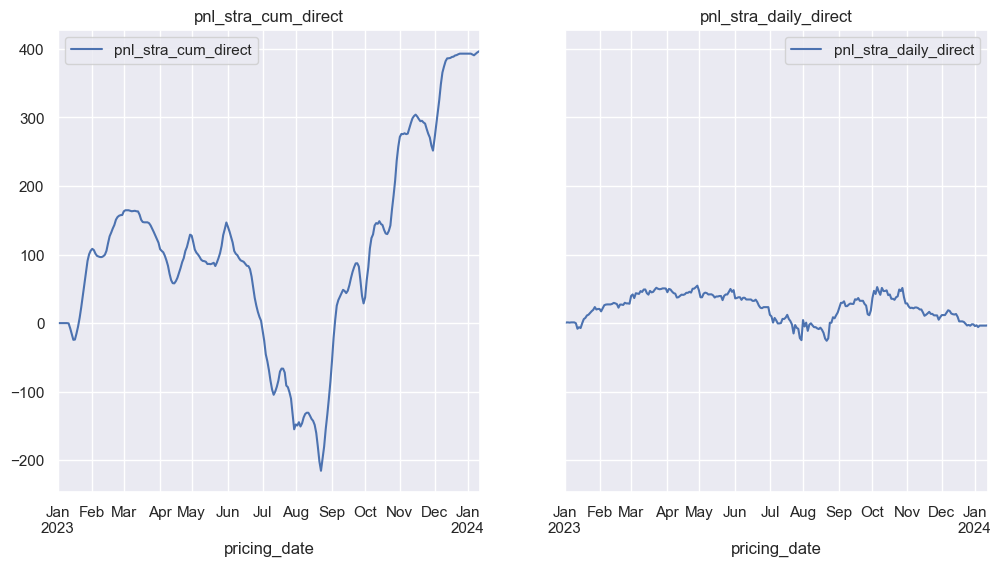

In [20]:
for est in [10]:
    path = 'experiments/test'

    if not os.path.exists(path): os.mkdir(path)

    path += '/estimators/'
    if not os.path.exists(path): os.mkdir(path)

    data.interpolate('linear', inplace=True)
    data.dropna()

    results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=True, n_estimators=est)
    print(results['model'])

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3',
       'year_sin', 'month_sin', 'day_sin', 'dow_sin', 'year_num', 'month_num',
       'day_num', 'dow_num'],

XGBRegressor(base_score='2.381272E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOB

KeyboardInterrupt: 

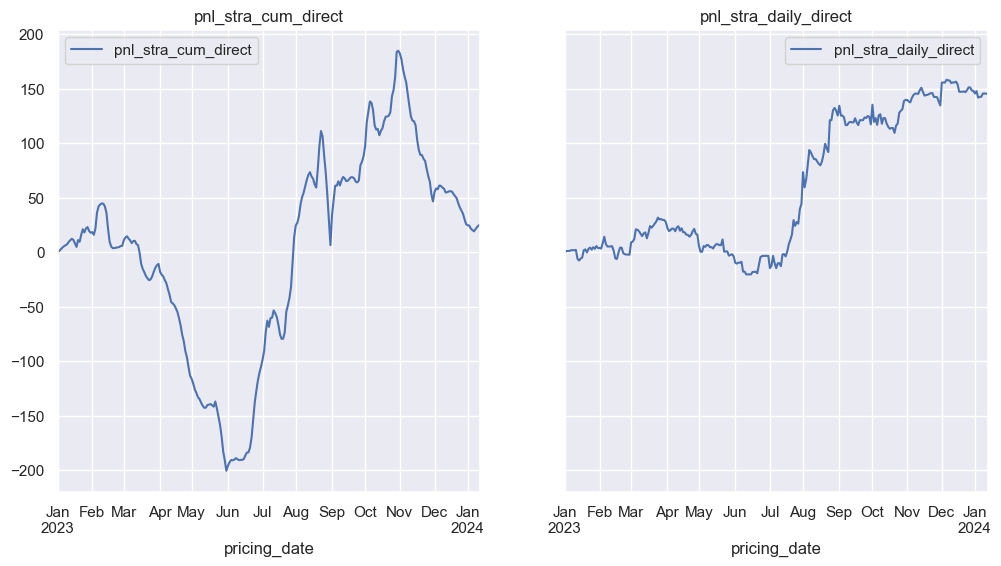

In [21]:
for est in [100, 500, 1000]:
    path = 'experiments/test'

    if not os.path.exists(path): os.mkdir(path)

    path += '/estimators/'
    if not os.path.exists(path): os.mkdir(path)

    data.interpolate('linear', inplace=True)
    data.dropna()

    results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=True, n_estimators=est)
    print(results['model'])

In [23]:
columns = data.drop(columns='F380 M2/M3').columns
columns

Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3',
       'year_sin', 'month_sin', 'day_sin', 'dow_sin', 'year_num', 'month_num',
       'day_num', 'dow_num'],
      dtype='

In [24]:
for col in list(columns):
    data[f'neg_{col}'] = -data[col]

data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  neg__rgp_10_sz_3  neg__rgp_11_sz_3  \
pricing_date                         ...                                       
2017-01-10       0.0     0.0    0.0  ...              -0.0              -0.0   
2017-01-11       0.0     0.0    0.0  ...              -0.0              -0.0   
2017-01-12       0.0     0.0    0.0  ...              -0.0              -0.0   
2017-01-13       0.0     0.0    0.0  ...              -0.0              -0.0   
2017-01-16       0.0     0.0    0.0  ...              -0.0              -0.0   
...              ...     ...    ...  ...               ...               ...   
2024-02-26       0.0     0.0    0.0  ...              -0.0              -0.0   
2024-02-27       0.0     0.0    0.0  ...              -0.0              -0.0   
2024-02-28       0.0     0.0    0.0  ...              -0.0              -0.0   
2024-02-29       0.0     0.0    0.0  ...              -0.0              -0.0   
2024-03-01       0.0     0.0    0.0  ...              -0.0              -0.0   

              neg_year_sin  neg_month_sin  neg_day_sin   neg_dow_sin  \
pricing_date                                                           
2017-01-10    2.172867e-02      -0.500000    -0.897805 -1.000000e+00   
2017-01-11    2.172867e-02      -0.500000    -0.790776 -1.224647e-16   
2017-01-12    2.172867e-02      -0.500000    -0.651372  1.000000e+00   
2017-01-13    2.172867e-02      -0.500000    -0.485302  2.449294e-16   
2017-01-16    2.172867e-02      -0.500000     0.101168 -0.000000e+00   
...                    ...            ...          ...           ...   
2024-02-26    2.449294e-16      -0.866025     0.848644 -0.000000e+00   
2024-02-27    2.449294e-16      -0.866025     0.724793 -1.000000e+00   
2024-02-28    2.449294e-16      -0.866025     0.571268 -1.224647e-16   
2024-02-29    2.449294e-16      -0.866025     0.394356  1.000000e+00   
2024-03-01    2.449294e-16      -1.000000    -0.201299  2.449294e-16   

              neg_year_num  neg_month_num  neg_day_num  neg_dow_num  
pricing_date                                                         
2017-01-10           -2017             -1          -10           -1  
2017-01-11           -2017             -1          -11           -2  
2017-01-12           -2017             -1          -12           -3  
2017-01-13           -2017             -1          -13           -4  
2017-01-16           -2017             -1          -16            0  
...                    ...            ...          ...          ...  
2024-02-26           -2024             -2          -26            0  
2024-02-27           -2024             -2          -27           -1  
2024-02-28           -2024             -2          -28           -2  
2024-02-29           -2024             -2          -29           -3  
2024-03-01           -2024             -3           -1           -4  

[1864 rows x 149 columns]

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG',
       ...
       'neg__rgp_10_sz_3', 'neg__rgp_11_sz_3', 'neg_year_sin', 'neg_month_sin',
       'neg_day_sin', 'neg_dow_sin', 'neg_year_num', 'neg_month_num',
       'neg_day_num', 'neg_dow_num'],
      dtype='object', length=148)
(566, 149) (566,)
(30, 149) (30,)
(670, 149) (670,)
(30, 149) (30,)
(770, 149) (770,)
(30, 149) (30,)
(870, 149) (870,)
(30, 149) (30,)
(970, 149) (970,)
(30, 149) (30,)


XGBRegressor(base_score='2.381272E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


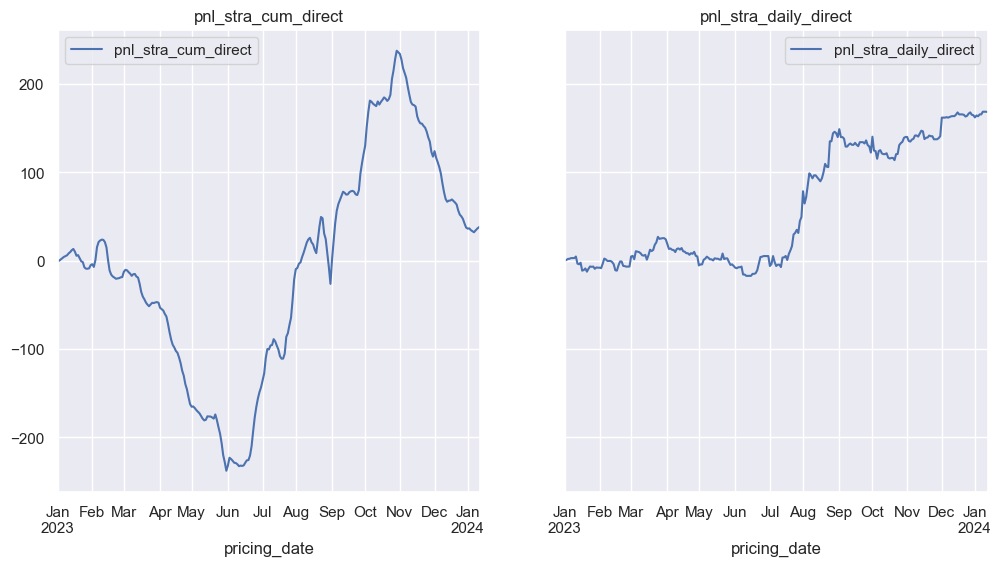

In [25]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/neg_cols_estimators10/'
if not os.path.exists(path): os.mkdir(path)

data.interpolate('linear', inplace=True)
data.dropna()

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=True, n_estimators=100)
print(results['model'])

In [36]:
data = pd.read_csv('data/data_2024-02-02.csv')
data.pricing_date = pd.to_datetime(data.pricing_date)
data.set_index('pricing_date', inplace=True)
# data = data[[*data.columns[24:-4], *data.columns[-1:]]]
data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)


data['year_num'] = data.index.year
data['month_num'] = data.index.month
data['day_num'] = data.index.day
data['dow_num'] = data.index.dayofweek

data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  _rgp_11_sz_3  F380 M2/M3  \
pricing_date                         ...                             
2017-01-10       0.0     0.0    0.0  ...           0.0        1.50   
2017-01-11       0.0     0.0    0.0  ...           0.0        1.30   
2017-01-12       0.0     0.0    0.0  ...           0.0        1.70   
2017-01-13       0.0     0.0    0.0  ...           0.0        1.85   
2017-01-16       0.0     0.0    0.0  ...           0.0        2.00   
...              ...     ...    ...  ...           ...         ...   
2024-02-26       0.0     0.0    0.0  ...           0.0         NaN   
2024-02-27       0.0     0.0    0.0  ...           0.0         NaN   
2024-02-28       0.0     0.0    0.0  ...           0.0         NaN   
2024-02-29       0.0     0.0    0.0  ...           0.0         NaN   
2024-03-01       0.0     0.0    0.0  ...           0.0         NaN   

                  year_sin  month_sin   day_sin       dow_sin  year_num  \
pricing_date                                                              
2017-01-10   -2.172867e-02   0.500000  0.897805  1.000000e+00      2017   
2017-01-11   -2.172867e-02   0.500000  0.790776  1.224647e-16      2017   
2017-01-12   -2.172867e-02   0.500000  0.651372 -1.000000e+00      2017   
2017-01-13   -2.172867e-02   0.500000  0.485302 -2.449294e-16      2017   
2017-01-16   -2.172867e-02   0.500000 -0.101168  0.000000e+00      2017   
...                    ...        ...       ...           ...       ...   
2024-02-26   -2.449294e-16   0.866025 -0.848644  0.000000e+00      2024   
2024-02-27   -2.449294e-16   0.866025 -0.724793  1.000000e+00      2024   
2024-02-28   -2.449294e-16   0.866025 -0.571268  1.224647e-16      2024   
2024-02-29   -2.449294e-16   0.866025 -0.394356 -1.000000e+00      2024   
2024-03-01   -2.449294e-16   1.000000  0.201299 -2.449294e-16      2024   

              month_num  day_num  dow_num  
pricing_date                               
2017-01-10            1       10        1  
2017-01-11            1       11        2  
2017-01-12            1       12        3  
2017-01-13            1       13        4  
2017-01-16            1       16        0  
...                 ...      ...      ...  
2024-02-26            2       26        0  
2024-02-27            2       27        1  
2024-02-28            2       28        2  
2024-02-29            2       29        3  
2024-03-01            3        1        4  

[1864 rows x 75 columns]

In [38]:
data['target_ewm30'] = data['F380 M2/M3'].ewm(span=30, adjust=True).mean()
data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  F380 M2/M3      year_sin  month_sin  \
pricing_date                         ...                                        
2017-01-10       0.0     0.0    0.0  ...        1.50 -2.172867e-02   0.500000   
2017-01-11       0.0     0.0    0.0  ...        1.30 -2.172867e-02   0.500000   
2017-01-12       0.0     0.0    0.0  ...        1.70 -2.172867e-02   0.500000   
2017-01-13       0.0     0.0    0.0  ...        1.85 -2.172867e-02   0.500000   
2017-01-16       0.0     0.0    0.0  ...        2.00 -2.172867e-02   0.500000   
...              ...     ...    ...  ...         ...           ...        ...   
2024-02-26       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-02-27       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-02-28       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-02-29       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-03-01       0.0     0.0    0.0  ...         NaN -2.449294e-16   1.000000   

               day_sin       dow_sin  year_num  month_num  day_num  dow_num  \
pricing_date                                                                  
2017-01-10    0.897805  1.000000e+00      2017          1       10        1   
2017-01-11    0.790776  1.224647e-16      2017          1       11        2   
2017-01-12    0.651372 -1.000000e+00      2017          1       12        3   
2017-01-13    0.485302 -2.449294e-16      2017          1       13        4   
2017-01-16   -0.101168  0.000000e+00      2017          1       16        0   
...                ...           ...       ...        ...      ...      ...   
2024-02-26   -0.848644  0.000000e+00      2024          2       26        0   
2024-02-27   -0.724793  1.000000e+00      2024          2       27        1   
2024-02-28   -0.571268  1.224647e-16      2024          2       28        2   
2024-02-29   -0.394356 -1.000000e+00      2024          2       29        3   
2024-03-01    0.201299 -2.449294e-16      2024          3        1        4   

              target_ewm30  
pricing_date                
2017-01-10        1.500000  
2017-01-11        1.396667  
2017-01-12        1.504591  
2017-01-13        1.599764  
2017-01-16        1.690827  
...                    ...  
2024-02-26        1.254723  
2024-02-27        1.254723  
2024-02-28        1.254723  
2024-02-29        1.254723  
2024-03-01        1.254723  

[1864 rows x 76 columns]

In [41]:
data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  F380 M2/M3      year_sin  month_sin  \
pricing_date                         ...                                        
2017-01-10       0.0     0.0    0.0  ...        1.50 -2.172867e-02   0.500000   
2017-01-11       0.0     0.0    0.0  ...        1.30 -2.172867e-02   0.500000   
2017-01-12       0.0     0.0    0.0  ...        1.70 -2.172867e-02   0.500000   
2017-01-13       0.0     0.0    0.0  ...        1.85 -2.172867e-02   0.500000   
2017-01-16       0.0     0.0    0.0  ...        2.00 -2.172867e-02   0.500000   
...              ...     ...    ...  ...         ...           ...        ...   
2024-02-26       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-02-27       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-02-28       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-02-29       0.0     0.0    0.0  ...         NaN -2.449294e-16   0.866025   
2024-03-01       0.0     0.0    0.0  ...         NaN -2.449294e-16   1.000000   

               day_sin       dow_sin  year_num  month_num  day_num  dow_num  \
pricing_date                                                                  
2017-01-10    0.897805  1.000000e+00      2017          1       10        1   
2017-01-11    0.790776  1.224647e-16      2017          1       11        2   
2017-01-12    0.651372 -1.000000e+00      2017          1       12        3   
2017-01-13    0.485302 -2.449294e-16      2017          1       13        4   
2017-01-16   -0.101168  0.000000e+00      2017          1       16        0   
...                ...           ...       ...        ...      ...      ...   
2024-02-26   -0.848644  0.000000e+00      2024          2       26        0   
2024-02-27   -0.724793  1.000000e+00      2024          2       27        1   
2024-02-28   -0.571268  1.224647e-16      2024          2       28        2   
2024-02-29   -0.394356 -1.000000e+00      2024          2       29        3   
2024-03-01    0.201299 -2.449294e-16      2024          3        1        4   

              target_ewm30  
pricing_date                
2017-01-10        1.500000  
2017-01-11        1.396667  
2017-01-12        1.504591  
2017-01-13        1.599764  
2017-01-16        1.690827  
...                    ...  
2024-02-26        1.254723  
2024-02-27        1.254723  
2024-02-28        1.254723  
2024-02-29        1.254723  
2024-03-01        1.254723  

[1864 rows x 76 columns]

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3',
       'year_sin', 'month_sin', 'day_sin', 'dow_sin', 'year_num', 'month_num',
       'day_num', 'dow_num', 

XGBRegressor(base_score='2.3757017E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


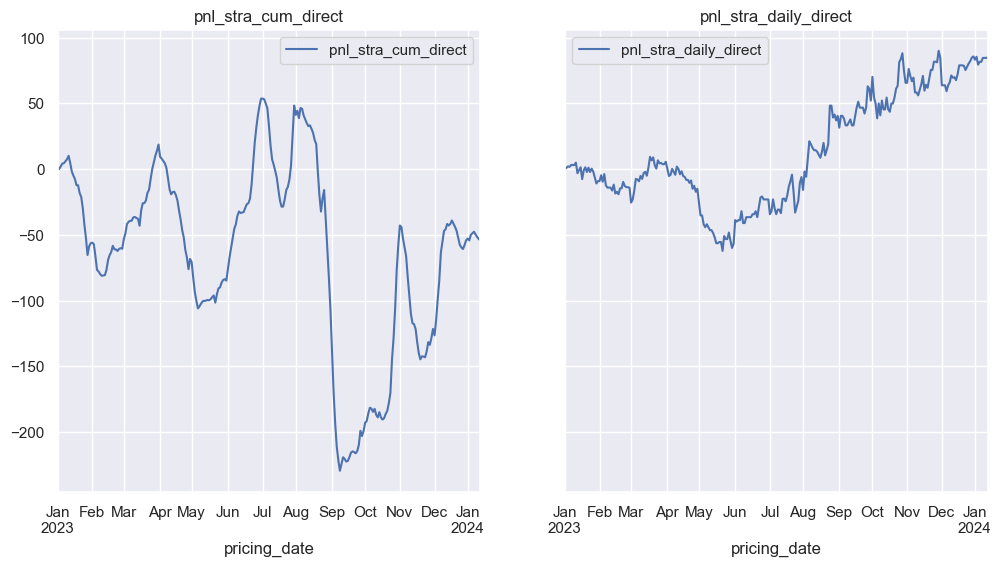

In [42]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/neg_cols_estimators10/'
if not os.path.exists(path): os.mkdir(path)

data.interpolate('linear', inplace=True)
data.dropna()

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=True, n_estimators=100)
print(results['model'])

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG',
       ...
       'ewma__rgp_10_sz_3', 'ewma__rgp_11_sz_3', 'ewma_year_sin',
       'ewma_month_sin', 'ewma_day_sin', 'ewma_dow_sin', 'ewma_year_num',
       'ewma_month_num', 'ewma_day_num', 'ewma_dow_num'],
      dtype='object', length=222)
(566, 223) (566,)
(30, 223) (30,)
(670, 223) (670,)
(30, 223) (30,)
(770, 223) (770,)
(30, 223) (30,)
(870, 223) (870,)
(30, 223) (30,)
(970, 223) (970,)
(30, 223) (30,)


XGBRegressor(base_score='2.381272E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


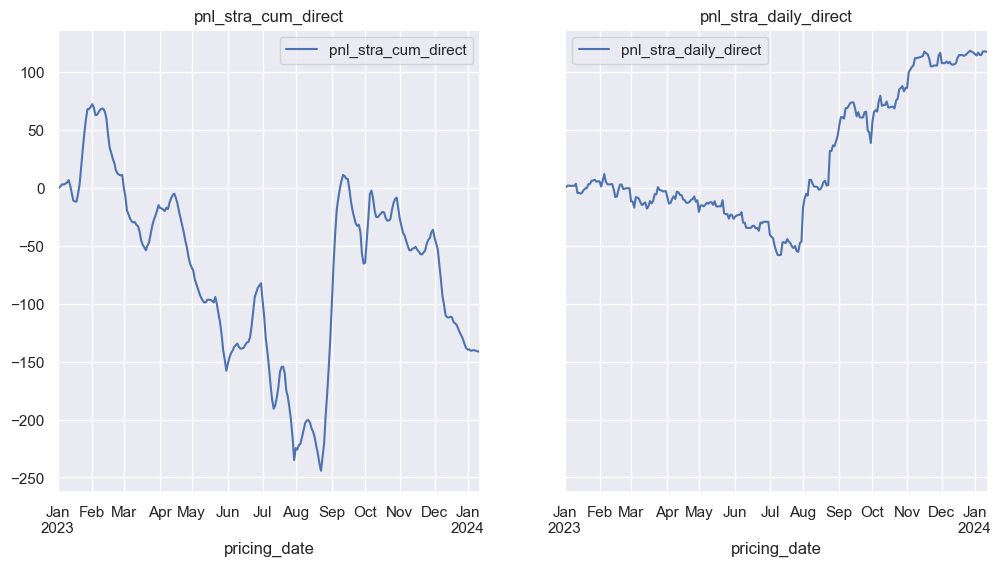

In [32]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/neg_cols_estimators10/'
if not os.path.exists(path): os.mkdir(path)

data.interpolate('linear', inplace=True)
data.dropna()

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=True, n_estimators=100)
print(results['model'])

In [35]:
results['model']

XGBRegressor(base_score='2.381272E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard
import xgboost as xgb

model = results['model']

# model_name = 'experiments/models/model-partial-cols=70.model'

# model = xgb.XGBRegressor(n_estimators=1500, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
# model.load_model(model_name)

# X_test.drop(columns='rolling_target5', inplace=True)
X_test = data.copy()
X_test.drop(columns='F380 M2/M3', inplace=True)
X_test = X_test
y_test = data['F380 M2/M3']
# X_test.drop(columns='F380 M2/M3', inplace=True)

explainer = RegressionExplainer(model, X_test, y_test)
ExplainerDashboard(explainer, depth=10).run()

Changing class type to XGBRegressionExplainer...


Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3',
       'year_sin', 'month_sin', 'day_sin', 'dow_sin'],
      dtype='object')
(570, 70) (570,)
(30, 70) (30,)

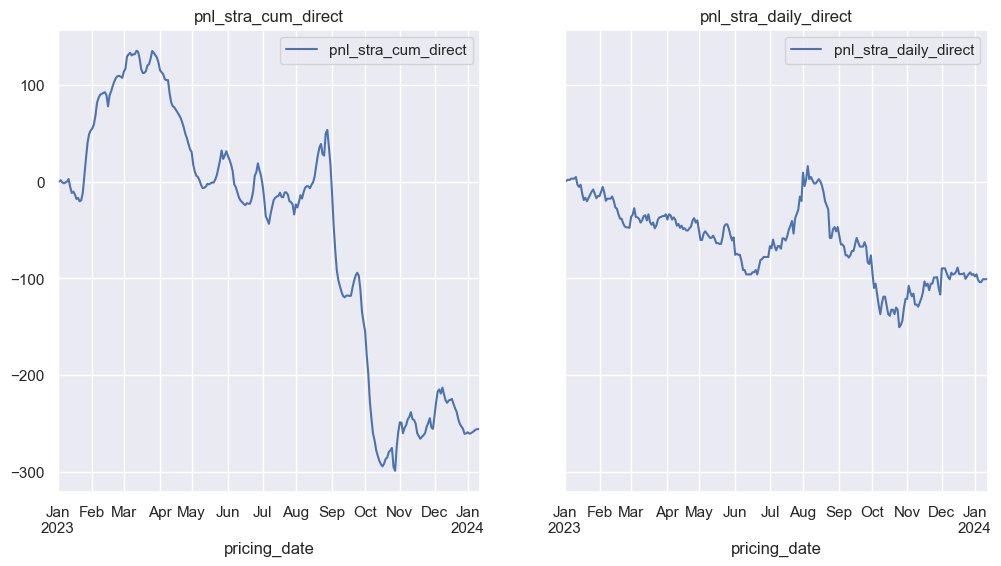

In [7]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/all_columns_2023/'
if not os.path.exists(path): os.mkdir(path)

data.interpolate('linear', inplace=True)
data.dropna()

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=False)

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3',
       'year_sin', 'month_sin', 'day_sin', 'dow_sin', 'year_num', 'month_num',
       'day_num', 'dow_num'],

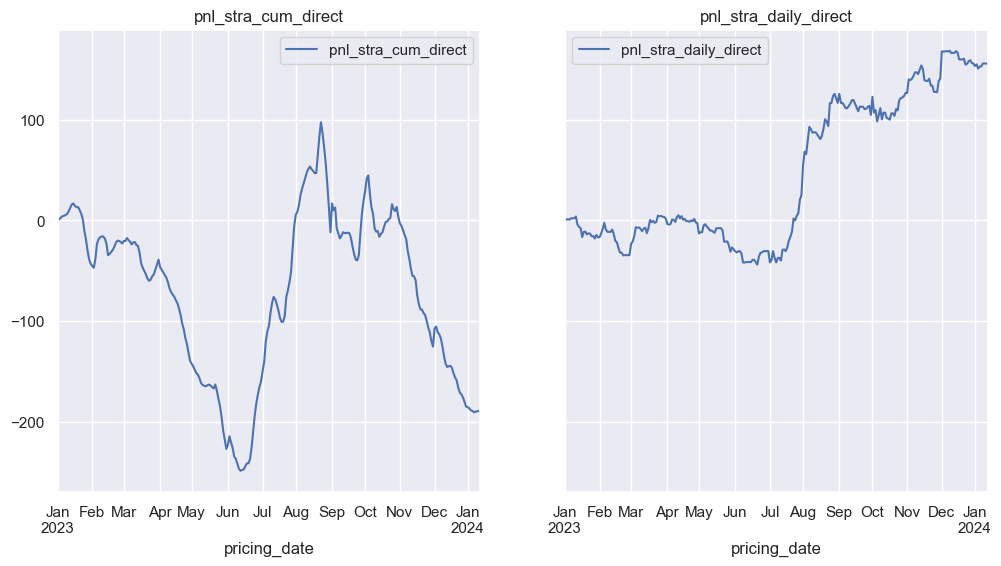

In [11]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/all_columns_2023_new_date_cols/'
if not os.path.exists(path): os.mkdir(path)

data.interpolate('linear', inplace=True)
data.dropna(inplace=True)

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=True)

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3',
       'year_sin', 'month_sin', 'day_sin', 'dow_sin'],
      dtype='object')
(566, 71) (566,)
(30, 71) (30,)

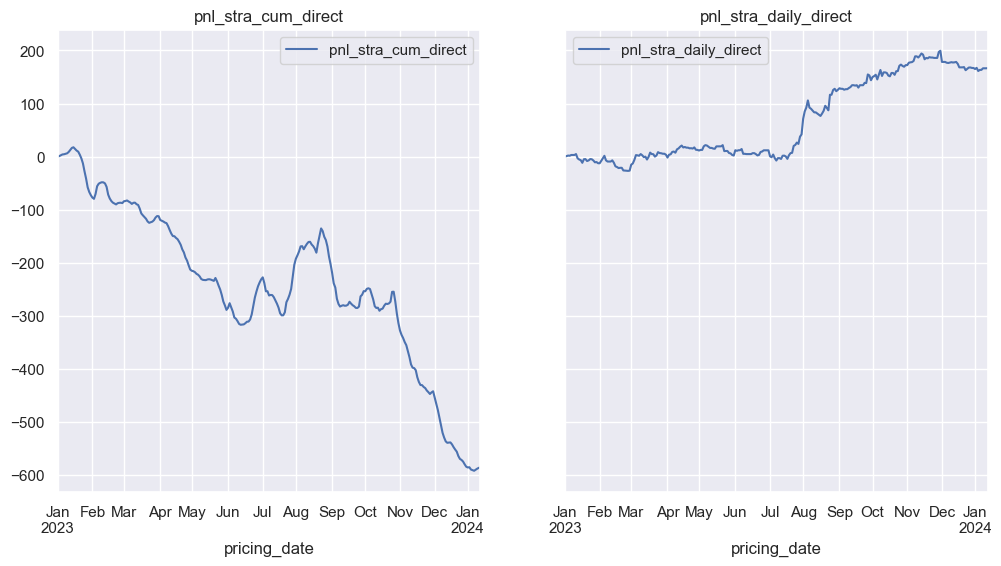

In [8]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/all_columns_2023/'
if not os.path.exists(path): os.mkdir(path)

data.interpolate('linear', inplace=True)
data.dropna(inplace=True)

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=True)

In [9]:
results.keys()

dict_keys(['results_df', 'pnl_path', 'plot_path', 'model'])

In [51]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard
import xgboost as xgb

model = results['model']

# model_name = 'experiments/models/model-partial-cols=70.model'

# model = xgb.XGBRegressor(n_estimators=1500, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
# model.load_model(model_name)

# X_test.drop(columns='rolling_target5', inplace=True)
X_test = data.copy()
X_test.drop(columns='F380 M2/M3', inplace=True)
X_test = X_test.loc['2023-01-01':]
y_test = data.loc['2023-01-01':]['F380 M2/M3']
# X_test.drop(columns='F380 M2/M3', inplace=True)

explainer = RegressionExplainer(model, X_test, y_test)
ExplainerDashboard(explainer).run()

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [52]:
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

In [53]:
import shap

shap.__version__

'0.44.0'

In [22]:
def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, use_rolling=False):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    model_name = f'experiments/models/model-{model_suffix}-{today_date}.model'
    
    # create a target feature class
    target_feature = TargetFeature(path, data, test_start, test_end)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    # data = data[columns]
    print('Data columns:', data.columns)
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_rolling:
            train_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target, rolling]].values
            valid_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[[target, rolling]].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)

            # normalize rolling
            train_temp['rolling_target5'] = target_feature.scaler.transform(train_temp[['rolling_target5']])
            valid_temp['rolling_target5'] = target_feature.scaler.transform(valid_temp[['rolling_target5']])
        else:
            train_temp[target_col] = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            valid_temp[target_col] = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        train_dm = xgb.DMatrix(train_temp.drop(columns=target_col), label=train_temp[target_col])
        valid_dm = xgb.DMatrix(valid_temp.drop(columns=target_col), label=valid_temp[target_col])

        if idx == 0:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10, custom_metric=custom_pnl_10)
        else:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10,
                              xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_rolling:
        full_train[[target_col, 'rolling_target5']] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                    include_past=True)[[target, rolling]].values
    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)

    if use_rolling:
        # normalize data
        full_train['rolling_target5'] = target_feature.scaler.transform(full_train[['rolling_target5']])

    train_dm = xgb.DMatrix(full_train.drop(columns=target_col), label=full_train[target_col])

    model = xgb.train(params, train_dm, evals=[(train_dm, 'train')],
                      maximize=True, early_stopping_rounds=10,
                      xgb_model=model_name, custom_metric=custom_pnl_10)

    model.save_model(model_name)

    return model, train, test, scaler, target_feature


def get_columns(columns_selection, model):
    if columns_selection == 'xgboost':
        scores = model.get_score(importance_type='gain')
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] > 30]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_rolling=False):
    # model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, path=results_folder)

    # columns = get_columns(columns_selection, model)
    # print(columns)
    # columns = [x for x in columns if not x.startswith('rolling')]
    # print('Selected columns:', columns)
    columns = data.drop(columns='F380 M2/M3').columns
    
    # refit the model with selected columns
    model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                             model_suffix='partial', columns=columns, path=results_folder)
    

    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    testx = testx[columns]

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_rolling:
                        # get rolling targets
                        rolling_target = current_targets.rolling(5).mean()
                        rolling_target.dropna(inplace=True)
                        
                        # normalize rolling targets
                        try:
                            rolling_target = pd.DataFrame(target_feature.scaler.transform(rolling_target),
                                                        index=rolling_target.index)
                        except ValueError:
                            rolling_target = pd.DataFrame(
                                target_feature.scaler.transform(rolling_target.values.reshape(-1, 1)),
                                index=rolling_target.index)

                        # put the new value to test set
                        try:
                            testx['rolling_target5'] = rolling_target.iloc[-1, 0]
                        except KeyError:
                            pass

                        # # get rolling targets
                        # rolling_target = current_targets.rolling(5).mean()
                        # rolling_target.dropna(inplace=True)

                        # # normalize rolling targets
                        # try:
                        #     rolling_target = pd.DataFrame(target_feature.scaler.transform(rolling_target),
                        #                                   index=rolling_target.index)
                        # except ValueError:
                        #     rolling_target = pd.DataFrame(
                        #         target_feature.scaler.transform(rolling_target.values.reshape(-1, 1)),
                        #         index=rolling_target.index)
                            
                    # convert test to DMatrix
                    test_dm = xgb.DMatrix(testx)

                    # get predictions
                    prediction = model.predict(test_dm)

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_rolling:
                        # append new rolling value to the predicted feature column
                        inverse = target_feature.scaler.inverse_transform(testx[['rolling_target5']])
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_feature', inverse)

                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'pnl_path': f'{results_folder}/daily_pnl-for-{test_start}.png',
            'plot_path': f'{results_folder}/plot-for-{test_start}.png', 'model': model}

In [18]:
data = pd.read_csv('data/data_2024-02-02.csv')
data.pricing_date = pd.to_datetime(data.pricing_date)
data.set_index('pricing_date', inplace=True)
# data = data[[*data.columns[24:-4], *data.columns[-1:]]]
data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)
data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  _rgp_07_sz_3  _rgp_08_sz_3  \
pricing_date                         ...                               
2017-01-10       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-11       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-12       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-13       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-16       0.0     0.0    0.0  ...           0.0           0.0   
...              ...     ...    ...  ...           ...           ...   
2024-02-26       0.0     0.0    0.0  ...           0.0           0.0   
2024-02-27       0.0     0.0    0.0  ...           0.0           0.0   
2024-02-28       0.0     0.0    0.0  ...           0.0           0.0   
2024-02-29       0.0     0.0    0.0  ...           0.0           0.0   
2024-03-01       0.0     0.0    0.0  ...           0.0           0.0   

              _rgp_09_sz_3  _rgp_10_sz_3  _rgp_11_sz_3  F380 M2/M3  \
pricing_date                                                         
2017-01-10        0.000000           0.0           0.0        1.50   
2017-01-11        0.000000           0.0           0.0        1.30   
2017-01-12        0.000000           0.0           0.0        1.70   
2017-01-13        0.000000           0.0           0.0        1.85   
2017-01-16        0.000000           0.0           0.0        2.00   
...                    ...           ...           ...         ...   
2024-02-26       65.555556           0.0           0.0         NaN   
2024-02-27       65.555556           0.0           0.0         NaN   
2024-02-28       65.555556           0.0           0.0         NaN   
2024-02-29       30.000000           0.0           0.0         NaN   
2024-03-01        0.000000           0.0           0.0         NaN   

                  year_sin  month_sin   day_sin       dow_sin  
pricing_date                                                   
2017-01-10   -2.172867e-02   0.500000  0.897805  1.000000e+00  
2017-01-11   -2.172867e-02   0.500000  0.790776  1.224647e-16  
2017-01-12   -2.172867e-02   0.500000  0.651372 -1.000000e+00  
2017-01-13   -2.172867e-02   0.500000  0.485302 -2.449294e-16  
2017-01-16   -2.172867e-02   0.500000 -0.101168  0.000000e+00  
...                    ...        ...       ...           ...  
2024-02-26   -2.449294e-16   0.866025 -0.848644  0.000000e+00  
2024-02-27   -2.449294e-16   0.866025 -0.724793  1.000000e+00  
2024-02-28   -2.449294e-16   0.866025 -0.571268  1.224647e-16  
2024-02-29   -2.449294e-16   0.866025 -0.394356 -1.000000e+00  
2024-03-01   -2.449294e-16   1.000000  0.201299 -2.449294e-16  

[1864 rows x 71 columns]

In [19]:
columns = data.columns[:-5]
columns

Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3'],
      dtype='object')

In [20]:
for col in list(columns):
    data[f'neg_{col}'] = -data[col]

data

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  neg__rgp_02_sz_3  neg__rgp_03_sz_3  \
pricing_date                         ...                                       
2017-01-10       0.0     0.0    0.0  ...         -0.000000              -0.0   
2017-01-11       0.0     0.0    0.0  ...         -0.000000              -0.0   
2017-01-12       0.0     0.0    0.0  ...         -0.000000            -530.0   
2017-01-13       0.0     0.0    0.0  ...         -0.000000           -1060.0   
2017-01-16       0.0     0.0    0.0  ...         -0.000000           -1060.0   
...              ...     ...    ...  ...               ...               ...   
2024-02-26       0.0     0.0    0.0  ...        262.888889              -0.0   
2024-02-27       0.0     0.0    0.0  ...        307.333333              -0.0   
2024-02-28       0.0     0.0    0.0  ...        342.888889              -0.0   
2024-02-29       0.0     0.0    0.0  ...        267.333333              -0.0   
2024-03-01       0.0     0.0    0.0  ...        277.333333              -0.0   

              neg__rgp_04_sz_3  neg__rgp_05_sz_3  neg__rgp_06_sz_3  \
pricing_date                                                         
2017-01-10           -0.000000         -0.000000              -0.0   
2017-01-11           -0.000000         -0.000000              -0.0   
2017-01-12           -0.000000       -920.000000              -0.0   
2017-01-13           -0.000000       -615.000000              -0.0   
2017-01-16           -0.000000         -3.333333              -0.0   
...                        ...               ...               ...   
2024-02-26         -266.666667         -0.000000              -0.0   
2024-02-27         -266.666667         -0.000000              -0.0   
2024-02-28         -266.666667         -0.000000              -0.0   
2024-02-29         -266.666667         -0.000000              -0.0   
2024-03-01         -266.666667         -0.000000              -0.0   

              neg__rgp_07_sz_3  neg__rgp_08_sz_3  neg__rgp_09_sz_3  \
pricing_date                                                         
2017-01-10                -0.0              -0.0         -0.000000   
2017-01-11                -0.0              -0.0         -0.000000   
2017-01-12                -0.0              -0.0         -0.000000   
2017-01-13                -0.0              -0.0         -0.000000   
2017-01-16                -0.0              -0.0         -0.000000   
...                        ...               ...               ...   
2024-02-26                -0.0              -0.0        -65.555556   
2024-02-27                -0.0              -0.0        -65.555556   
2024-02-28                -0.0              -0.0        -65.555556   
2024-02-29                -0.0              -0.0        -30.000000   
2024-03-01                -0.0              -0.0         -0.000000   

              neg__rgp_10_sz_3  neg__rgp_11_sz_3  
pricing_date                                      
2017-01-

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG',
       ...
       'neg__rgp_02_sz_3', 'neg__rgp_03_sz_3', 'neg__rgp_04_sz_3',
       'neg__rgp_05_sz_3', 'neg__rgp_06_sz_3', 'neg__rgp_07_sz_3',
       'neg__rgp_08_sz_3', 'neg__rgp_09_sz_3', 'neg__rgp_10_sz_3',
       'neg__rgp_11_sz_3'],
      dtype='object', length=136)
[0]	valid-rmse:1.32334	valid-pnl:0.02988
[1]	valid-rmse:1.28906	valid-pnl:0.02988
[2]	valid-rmse:1.23948	valid-pnl:0.00379
[3]	valid-rmse:1.19260	valid-pnl:0.00379
[4]	valid-rmse:1.15401	valid-pnl:0.02033
[5]	valid-rmse:1.10641	valid-pnl:0.02033
[6]	valid-rmse:1.06506	valid-pnl:0.02033
[7]	valid-rmse:1.03533	valid-pnl:0.02033
[8]	valid-rmse:1.03102	valid-pnl:0.02033
[9]	valid-rmse:1.02066	valid-pnl:0.05777
[10]	valid-rmse:0.98643	valid-pnl:0.09099
[11]	valid-rmse:0.97547	valid-pnl:0.08292
[12]	valid-rmse:0.93194	valid-pnl:0.08292
[13]	valid-rmse:0.91258	valid-pnl:0.08292
[14]	valid-rm

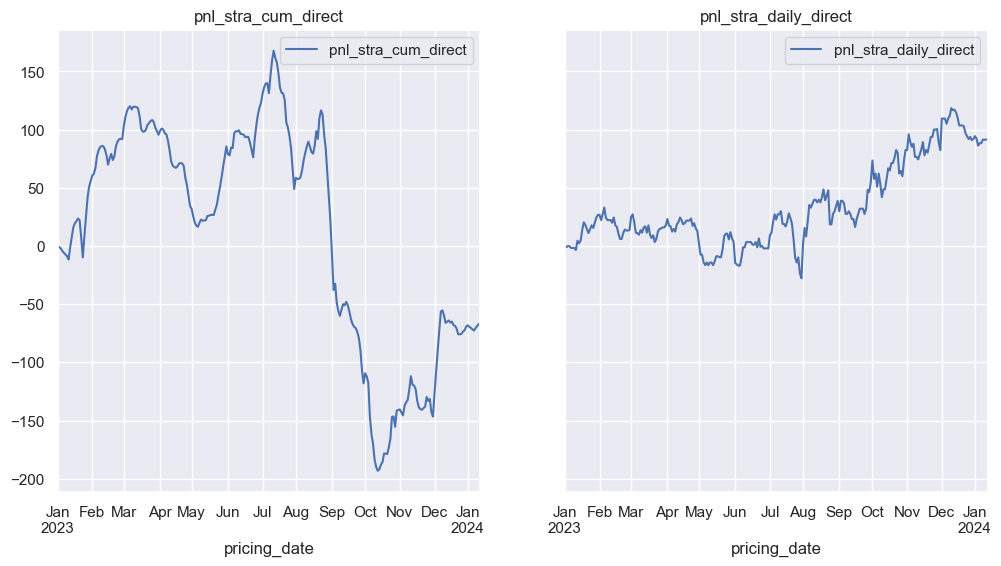

In [23]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/all_columns_2023/'
if not os.path.exists(path): os.mkdir(path)

data.interpolate('linear', inplace=True)
data.dropna()

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31', use_rolling=False)

Data columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG',
       ...
       'neg__rgp_02_sz_3', 'neg__rgp_03_sz_3', 'neg__rgp_04_sz_3',
       'neg__rgp_05_sz_3', 'neg__rgp_06_sz_3', 'neg__rgp_07_sz_3',
       'neg__rgp_08_sz_3', 'neg__rgp_09_sz_3', 'neg__rgp_10_sz_3',
       'neg__rgp_11_sz_3'],
      dtype='object', length=136)
[0]	valid-rmse:1.32699	valid-pnl:-0.00000
[1]	valid-rmse:1.29469	valid-pnl:-0.00000
[2]	valid-rmse:1.26597	valid-pnl:-0.00000
[3]	valid-rmse:1.24219	valid-pnl:-0.00000
[4]	valid-rmse:1.22034	valid-pnl:-0.00000
[5]	valid-rmse:1.19496	valid-pnl:-0.00000
[6]	valid-rmse:1.16893	valid-pnl:-0.00000
[7]	valid-rmse:1.14361	valid-pnl:0.00406
[8]	valid-rmse:1.11606	valid-pnl:-0.00235
[9]	valid-rmse:1.09259	valid-pnl:0.00989
[10]	valid-rmse:1.07296	valid-pnl:0.00989
[11]	valid-rmse:1.03269	valid-pnl:-0.02053
[12]	valid-rmse:1.00424	valid-pnl:-0.02053
[13]	valid-rmse:0.97227	valid-pnl:-0.06600
[1

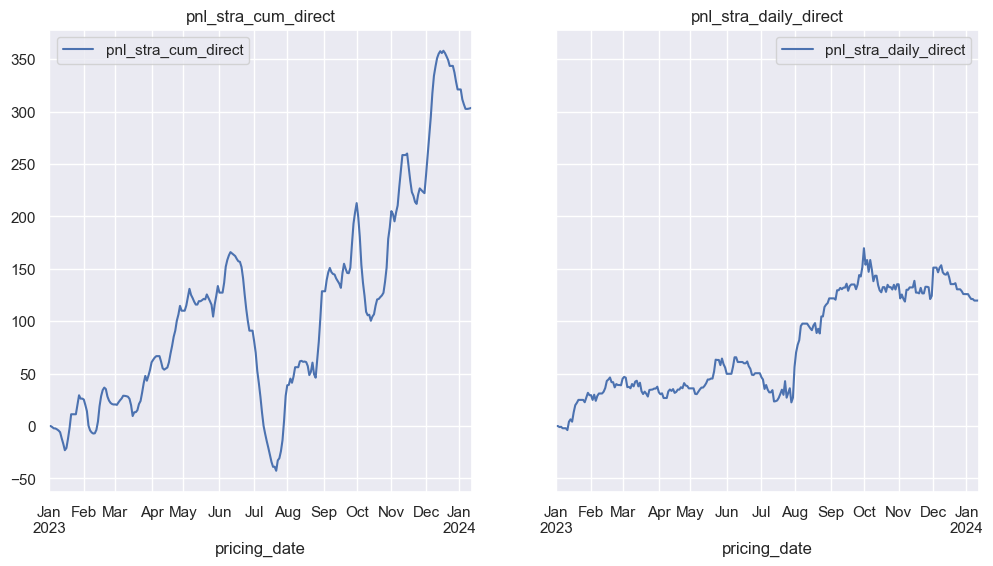

In [56]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/all_columns_2023/'
if not os.path.exists(path): os.mkdir(path)

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31')

In [26]:
all = data.columns.tolist()
selected = ['ARAMCOSG', 'BPSG', 'COASTAL', 'ENOC', 'GLENCORESG', 'GUNVORSG', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG', 'MERCURIARESOURCES', 'MERCURIASG', 'P66SG', 'PTT', 'RGES', 'SINOPECHKSG', 'SOCAR', 'TOTALSG', 'TRAFI', 'VITOLSG', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3', '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_07_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', 'year_sin', 'month_sin', 'neg_ARAMCOSG', 'neg_BPSG', 'neg_COASTAL', 'neg_ENOC', 'neg_GLENCORESG', 'neg_GUNVORSG', 'neg_HL', 'neg_ITGRES', 'neg_LUKOIL', 'neg_MACQUARIESG', 'neg_MERCURIARESOURCES', 'neg_MERCURIASG', 'neg_P66SG', 'neg_PTT', 'neg_RGES', 'neg_SIETCO', 'neg_SINOPECHKSG', 'neg_SOCAR', 'neg_TOTALSG', 'neg_TRAFI', 'neg_VITOLSG', 'neg__rgp_01_sz_3', 'neg__rgp_02_sz_3', 'neg__rgp_03_sz_3', 'neg__rgp_04_sz_3', 'neg__rgp_05_sz_3', 'neg__rgp_07_sz_3', 'neg__rgp_10_sz_3']

print(len(all), len(selected))
selected

137 57


['ARAMCOSG',
 'BPSG',
 'COASTAL',
 'ENOC',
 'GLENCORESG',
 'GUNVORSG',
 'LUKOIL',
 'MACQUARIESG',
 'MAERSKSG',
 'MERCURIARESOURCES',
 'MERCURIASG',
 'P66SG',
 'PTT',
 'RGES',
 'SINOPECHKSG',
 'SOCAR',
 'TOTALSG',
 'TRAFI',
 'VITOLSG',
 '_rgp_01_sz_3',
 '_rgp_02_sz_3',
 '_rgp_03_sz_3',
 '_rgp_04_sz_3',
 '_rgp_05_sz_3',
 '_rgp_07_sz_3',
 '_rgp_09_sz_3',
 '_rgp_10_sz_3',
 'year_sin',
 'month_sin',
 'neg_ARAMCOSG',
 'neg_BPSG',
 'neg_COASTAL',
 'neg_ENOC',
 'neg_GLENCORESG',
 'neg_GUNVORSG',
 'neg_HL',
 'neg_ITGRES',
 'neg_LUKOIL',
 'neg_MACQUARIESG',
 'neg_MERCURIARESOURCES',
 'neg_MERCURIASG',
 'neg_P66SG',
 'neg_PTT',
 'neg_RGES',
 'neg_SIETCO',
 'neg_SINOPECHKSG',
 'neg_SOCAR',
 'neg_TOTALSG',
 'neg_TRAFI',
 'neg_VITOLSG',
 'neg__rgp_01_sz_3',
 'neg__rgp_02_sz_3',
 'neg__rgp_03_sz_3',
 'neg__rgp_04_sz_3',
 'neg__rgp_05_sz_3',
 'neg__rgp_07_sz_3',
 'neg__rgp_10_sz_3']

# Using ALL columns

In [30]:
def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    model_name = f'experiments/models/model-{model_suffix}-{today_date}-len{len(columns)}.model'
    
    # create a target feature class
    target_feature = TargetFeature(path, data, test_start, test_end)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    if columns:
        data = data[columns]
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    for idx in range(300):
        train_temp, valid_temp = iterate(train, idx, low=False)
        
        if len(valid_temp) < 10:
            break
        
        # get rolling and target columns
        train_temp[[target_col, 'rolling_target5']] = \
            target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                              include_past=True)[[target, rolling]].values
        valid_temp[[target_col, 'rolling_target5']] = \
            target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                              include_past=True)[[target, rolling]].values
            
        train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        train_temp.dropna(inplace=True)
        valid_temp.dropna(inplace=True)
        
        # normalize rolling
        train_temp['rolling_target5'] = target_feature.scaler.transform(train_temp[['rolling_target5']])
        valid_temp['rolling_target5'] = target_feature.scaler.transform(valid_temp[['rolling_target5']])

        train_dm = xgb.DMatrix(train_temp.drop(columns=target_col), label=train_temp[target_col])
        valid_dm = xgb.DMatrix(valid_temp.drop(columns=target_col), label=valid_temp[target_col])

        if idx == 0:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10, custom_metric=custom_pnl_10)
        else:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10,
                              xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)
    
    if final_refit:
        full_train = train.copy()
        full_train[[target_col, 'rolling_target5']] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                        include_past=True)[[target, rolling]].values
        full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        full_train.dropna(inplace=True)

        # normalize data
        full_train['rolling_target5'] = target_feature.scaler.transform(full_train[['rolling_target5']])

        train_dm = xgb.DMatrix(full_train.drop(columns=target_col), label=full_train[target_col])

        model = xgb.train(params, train_dm, evals=[(train_dm, 'train')],
                          maximize=True, early_stopping_rounds=10,
                          xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)

    return model, train, test, scaler, target_feature


def get_columns(columns_selection, model):
    if columns_selection == 'xgboost':
        scores = model.get_score(importance_type='gain')
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] > 30]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost'):
    # model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, path=results_folder)

    # columns = get_columns(columns_selection, model)
    # print(columns)
    # columns = [x for x in columns if not x.startswith('rolling')]
    # print('Selected columns:', columns)
    
    columns = data.columns
    # columns = [c for c in columns.tolist() if c != 'F380 M2/M3']
    
    # refit the model with selected columns
    model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                             model_suffix='partial', columns=columns, path=results_folder)
    

    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    # iterate over values
    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T

                    testx.drop(columns='F380 M2/M3', inplace=True)
                    
                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values[['actual_target']]
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]

                    # get rolling targets
                    rolling_target = current_targets.rolling(5).mean()
                    rolling_target.dropna(inplace=True)

                    # normalize rolling targets
                    try:
                        rolling_target = pd.DataFrame(target_feature.scaler.transform(rolling_target),
                                                      index=rolling_target.index)
                    except ValueError:
                        rolling_target = pd.DataFrame(
                            target_feature.scaler.transform(rolling_target.values.reshape(-1, 1)),
                            index=rolling_target.index)

                    # put the new value to test set
                    try:
                        testx['rolling_target5'] = rolling_target.iloc[-1, 0]
                    except KeyError:
                        pass
                    else:
                        # convert test to DMatrix
                        test_dm = xgb.DMatrix(testx)

                        # get predictions
                        prediction = model.predict(test_dm)

                        # append new prediction to predicted target column
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                        # append new rolling value to the predicted feature column
                        inverse = target_feature.scaler.inverse_transform(testx[['rolling_target5']])
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_feature', inverse)

                        # record results
                        results_df = pd.concat([results_df, pd.DataFrame({
                            'pricing_date': testx.index,
                            'preds': prediction,
                            'target': current_values.loc[sliding_start_date, 'actual_target'],
                            'forecast_date': sliding_history.index.min()

                        })], ignore_index=True)

    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'pnl_path': f'{results_folder}/daily_pnl-for-{test_start}.png',
            'plot_path': f'{results_folder}/plot-for-{test_start}.png', 'model': model}

[0]	valid-rmse:1.32699	valid-pnl:-0.00000
[1]	valid-rmse:1.29469	valid-pnl:-0.00000
[2]	valid-rmse:1.26597	valid-pnl:-0.00000
[3]	valid-rmse:1.24219	valid-pnl:-0.00000
[4]	valid-rmse:1.22034	valid-pnl:-0.00000
[5]	valid-rmse:1.19496	valid-pnl:-0.00000
[6]	valid-rmse:1.16893	valid-pnl:-0.00000
[7]	valid-rmse:1.14361	valid-pnl:0.00406
[8]	valid-rmse:1.11606	valid-pnl:-0.00235
[9]	valid-rmse:1.09259	valid-pnl:0.00989
[10]	valid-rmse:1.07296	valid-pnl:0.00989
[11]	valid-rmse:1.03269	valid-pnl:-0.02053
[12]	valid-rmse:1.00424	valid-pnl:-0.02053
[13]	valid-rmse:0.97227	valid-pnl:-0.06600
[14]	valid-rmse:0.95356	valid-pnl:-0.04037
[15]	valid-rmse:0.93571	valid-pnl:-0.01550
[16]	valid-rmse:0.91857	valid-pnl:0.00861
[17]	valid-rmse:0.90283	valid-pnl:-0.01040
[18]	valid-rmse:0.88976	valid-pnl:-0.01040
[19]	valid-rmse:0.87879	valid-pnl:-0.01040
[0]	valid-rmse:1.81264	valid-pnl:0.23929
[1]	valid-rmse:1.75997	valid-pnl:-0.04752
[2]	valid-rmse:1.70927	valid-pnl:0.12154
[3]	valid-rmse:1.71556	valid-p

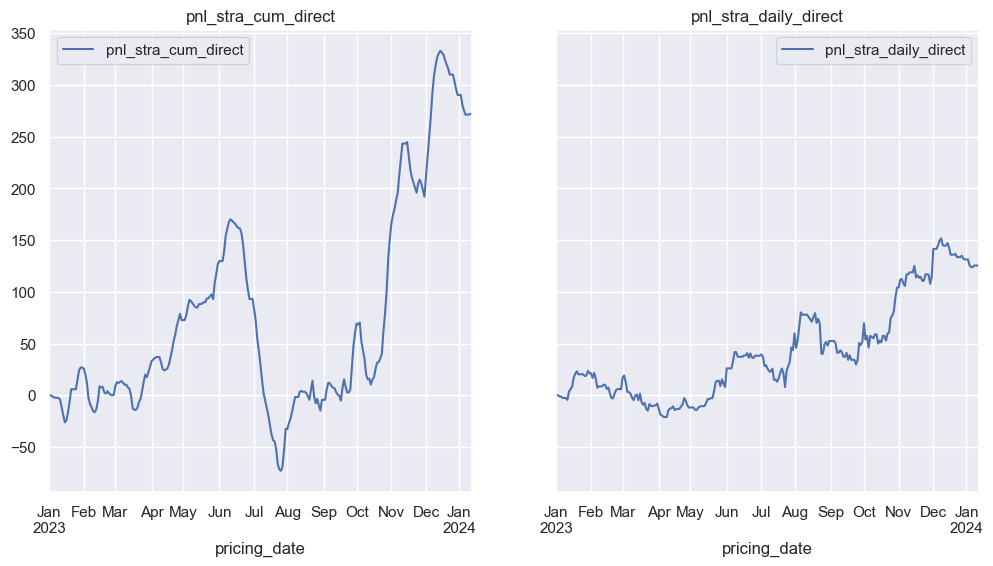

In [31]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/all_columns_2023_without_xgboost_fe/'
if not os.path.exists(path): os.mkdir(path)

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31')

In [29]:
data.columns

Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG',
       ...
       'neg__rgp_02_sz_3', 'neg__rgp_03_sz_3', 'neg__rgp_04_sz_3',
       'neg__rgp_05_sz_3', 'neg__rgp_06_sz_3', 'neg__rgp_07_sz_3',
       'neg__rgp_08_sz_3', 'neg__rgp_09_sz_3', 'neg__rgp_10_sz_3',
       'neg__rgp_11_sz_3'],
      dtype='object', length=137)

# 3 month halt

In [34]:
from datetime import timedelta

def train_model(data, train_end, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    model_name = f'experiments/models/model-{model_suffix}-train_end={train_end}-len{len(columns)}.model'
    
    # create a target feature class
    target_feature = TargetFeature(path, data, test_start, test_end)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    # split to train/test
    train = data[data.index <= train_end]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    for idx in range(300):
        train_temp, valid_temp = iterate(train, idx, low=False)
        
        if len(valid_temp) < 10:
            break
        
        # get rolling and target columns
        train_temp[[target_col, 'rolling_target5']] = \
            target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                              include_past=True)[[target, rolling]].values
        valid_temp[[target_col, 'rolling_target5']] = \
            target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                              include_past=True)[[target, rolling]].values
            
        train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        train_temp.dropna(inplace=True)
        valid_temp.dropna(inplace=True)
        
        # normalize rolling
        train_temp['rolling_target5'] = target_feature.scaler.transform(train_temp[['rolling_target5']])
        valid_temp['rolling_target5'] = target_feature.scaler.transform(valid_temp[['rolling_target5']])

        train_dm = xgb.DMatrix(train_temp.drop(columns=target_col), label=train_temp[target_col])
        valid_dm = xgb.DMatrix(valid_temp.drop(columns=target_col), label=valid_temp[target_col])

        if idx == 0:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10, custom_metric=custom_pnl_10)
        else:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10,
                              xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)
    
    if final_refit:
        full_train = train.copy()
        full_train[[target_col, 'rolling_target5']] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                        include_past=True)[[target, rolling]].values
        full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        full_train.dropna(inplace=True)

        # normalize data
        full_train['rolling_target5'] = target_feature.scaler.transform(full_train[['rolling_target5']])

        train_dm = xgb.DMatrix(full_train.drop(columns=target_col), label=full_train[target_col])

        model = xgb.train(params, train_dm, evals=[(train_dm, 'train')],
                          maximize=True, early_stopping_rounds=10,
                          xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)

    return model, train, test, scaler, target_feature


def get_columns(columns_selection, model):
    if columns_selection == 'xgboost':
        scores = model.get_score(importance_type='gain')
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] > 30]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost'):
    # model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, path=results_folder)

    # columns = get_columns(columns_selection, model)
    # print(columns)
    # columns = [x for x in columns if not x.startswith('rolling')]
    # print('Selected columns:', columns)
    
    columns = data.columns
    # columns = [c for c in columns.tolist() if c != 'F380 M2/M3']
    
    train_end_date = datetime.strptime(test_start, '%Y-%m-%d') - timedelta(days=90)
    train_end_date = str(train_end_date)[:10]
    
    # refit the model with selected columns
    model, train, test, scaler, target_feature = train_model(data.copy(), train_end=train_end_date, test_start=test_start, test_end=test_end, 
                                                             model_suffix='partial', columns=columns, path=results_folder)
    

    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    # iterate over values
    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T

                    testx.drop(columns='F380 M2/M3', inplace=True)
                    
                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values[['actual_target']]
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]

                    # get rolling targets
                    rolling_target = current_targets.rolling(5).mean()
                    rolling_target.dropna(inplace=True)

                    # normalize rolling targets
                    try:
                        rolling_target = pd.DataFrame(target_feature.scaler.transform(rolling_target),
                                                      index=rolling_target.index)
                    except ValueError:
                        rolling_target = pd.DataFrame(
                            target_feature.scaler.transform(rolling_target.values.reshape(-1, 1)),
                            index=rolling_target.index)

                    # put the new value to test set
                    try:
                        testx['rolling_target5'] = rolling_target.iloc[-1, 0]
                    except KeyError:
                        pass
                    else:
                        # convert test to DMatrix
                        test_dm = xgb.DMatrix(testx)

                        # get predictions
                        prediction = model.predict(test_dm)

                        # append new prediction to predicted target column
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                        # append new rolling value to the predicted feature column
                        inverse = target_feature.scaler.inverse_transform(testx[['rolling_target5']])
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_feature', inverse)

                        # record results
                        results_df = pd.concat([results_df, pd.DataFrame({
                            'pricing_date': testx.index,
                            'preds': prediction,
                            'target': current_values.loc[sliding_start_date, 'actual_target'],
                            'forecast_date': sliding_history.index.min()

                        })], ignore_index=True)

    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'pnl_path': f'{results_folder}/daily_pnl-for-{test_start}.png',
            'plot_path': f'{results_folder}/plot-for-{test_start}.png', 'model': model}

[0]	valid-rmse:1.32699	valid-pnl:-0.00000
[1]	valid-rmse:1.29469	valid-pnl:-0.00000
[2]	valid-rmse:1.26597	valid-pnl:-0.00000
[3]	valid-rmse:1.24219	valid-pnl:-0.00000
[4]	valid-rmse:1.22034	valid-pnl:-0.00000
[5]	valid-rmse:1.19496	valid-pnl:-0.00000
[6]	valid-rmse:1.16893	valid-pnl:-0.00000
[7]	valid-rmse:1.14361	valid-pnl:0.00406


[8]	valid-rmse:1.11606	valid-pnl:-0.00235
[9]	valid-rmse:1.09259	valid-pnl:0.00989
[10]	valid-rmse:1.07296	valid-pnl:0.00989
[11]	valid-rmse:1.03269	valid-pnl:-0.02053
[12]	valid-rmse:1.00424	valid-pnl:-0.02053
[13]	valid-rmse:0.97227	valid-pnl:-0.06600
[14]	valid-rmse:0.95356	valid-pnl:-0.04037
[15]	valid-rmse:0.93571	valid-pnl:-0.01550
[16]	valid-rmse:0.91857	valid-pnl:0.00861
[17]	valid-rmse:0.90283	valid-pnl:-0.01040
[18]	valid-rmse:0.88976	valid-pnl:-0.01040
[19]	valid-rmse:0.87879	valid-pnl:-0.01040
[0]	valid-rmse:1.81264	valid-pnl:0.23929
[1]	valid-rmse:1.75997	valid-pnl:-0.04752
[2]	valid-rmse:1.70927	valid-pnl:0.12154
[3]	valid-rmse:1.71556	valid-pnl:0.39041
[4]	valid-rmse:1.71417	valid-pnl:0.48493
[5]	valid-rmse:1.73204	valid-pnl:0.56541
[6]	valid-rmse:1.71449	valid-pnl:0.28254
[7]	valid-rmse:1.73178	valid-pnl:0.52994
[8]	valid-rmse:1.73078	valid-pnl:0.46038
[9]	valid-rmse:1.74067	valid-pnl:0.22468
[10]	valid-rmse:1.71141	valid-pnl:0.24547
[11]	valid-rmse:1.72446	valid-pnl:0.

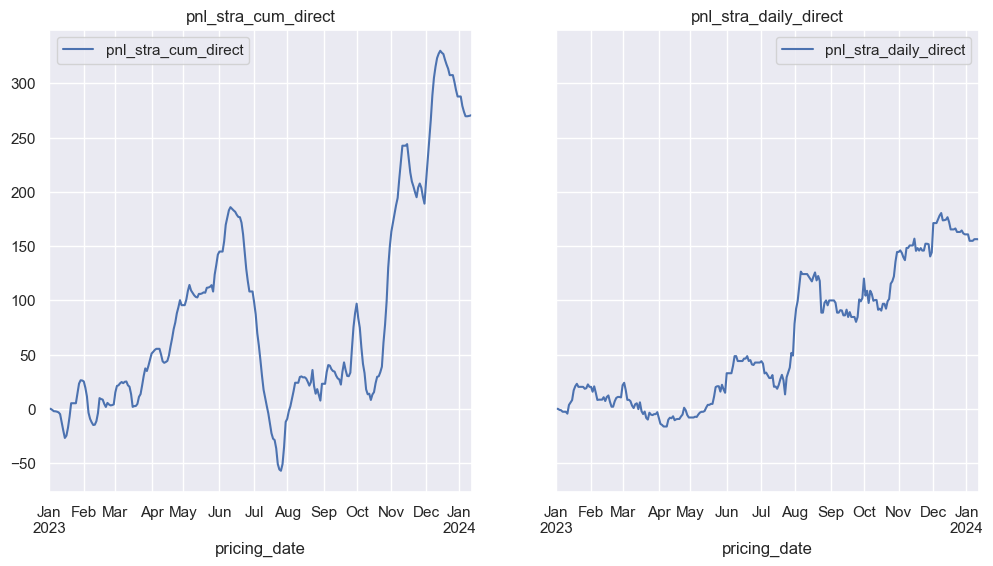

In [35]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/all_columns_2023_3month_halt/'
if not os.path.exists(path): os.mkdir(path)

results = get_predictions(data.copy(), path, '2023-01-01', '2023-12-31')

# Fusion model

In [57]:
data = pd.read_csv('data/data_2024-02-02.csv')
data.pricing_date = pd.to_datetime(data.pricing_date)
data.set_index('pricing_date', inplace=True)
# data = data[[*data.columns[24:-4], *data.columns[-1:]]]
data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)

orig_features = data.drop(columns='F380 M2/M3')
orig_features

ALVARI  ARAMCOSG  ARAMCOTF  ARCENERGY  BBEN  BPSG  BRIGHTOILSG  \
pricing_date                                                                   
2017-01-10       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-11       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-12       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-13       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2017-01-16       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
...              ...       ...       ...        ...   ...   ...          ...   
2024-02-26       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-27       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-28       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-02-29       0.0       0.0       0.0        0.0   0.0   0.0          0.0   
2024-03-01       0.0       0.0       0.0        0.0   0.0   0.0          0.0   

              BUYER1  BUYER2  CAOSG  ...  _rgp_06_sz_3  _rgp_07_sz_3  \
pricing_date                         ...                               
2017-01-10       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-11       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-12       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-13       0.0     0.0    0.0  ...           0.0           0.0   
2017-01-16       0.0     0.0    0.0  ...           0.0           0.0   
...              ...     ...    ...  ...           ...           ...   
2024-02-26       0.0     0.0    0.0  ...           0.0           0.0   
2024-02-27       0.0     0.0    0.0  ...           0.0           0.0   
2024-02-28       0.0     0.0    0.0  ...           0.0           0.0   
2024-02-29       0.0     0.0    0.0  ...           0.0           0.0   
2024-03-01       0.0     0.0    0.0  ...           0.0           0.0   

              _rgp_08_sz_3  _rgp_09_sz_3  _rgp_10_sz_3  _rgp_11_sz_3  \
pricing_date                                                           
2017-01-10             0.0      0.000000           0.0           0.0   
2017-01-11             0.0      0.000000           0.0           0.0   
2017-01-12             0.0      0.000000           0.0           0.0   
2017-01-13             0.0      0.000000           0.0           0.0   
2017-01-16             0.0      0.000000           0.0           0.0   
...                    ...           ...           ...           ...   
2024-02-26             0.0     65.555556           0.0           0.0   
2024-02-27             0.0     65.555556           0.0           0.0   
2024-02-28             0.0     65.555556           0.0           0.0   
2024-02-29             0.0     30.000000           0.0           0.0   
2024-03-01             0.0      0.000000           0.0           0.0   

                  year_sin  month_sin   day_sin       dow_sin  
pricing_date                                                   
2017-01-10   -2.172867e-02   0.500000  0.897805  1.000000e+00  
2017-01-11   -2.172867e-02   0.500000  0.790776  1.224647e-16  
2017-01-12   -2.172867e-02   0.500000  0.651372 -1.000000e+00  
2017-01-13   -2.172867e-02   0.500000  0.485302 -2.449294e-16  
2017-01-16   -2.172867e-02   0.500000 -0.101168  0.000000e+00  
...                    ...        ...       ...           ...  
2024-02-26   -2.449294e-16   0.866025 -0.848644  0.000000e+00  
2024-02-27   -2.449294e-16   0.866025 -0.724793  1.000000e+00  
2024-02-28   -2.449294e-16   0.866025 -0.571268  1.224647e-16  
2024-02-29   -2.449294e-16   0.866025 -0.394356 -1.000000e+00  
2024-03-01   -2.449294e-16   1.000000  0.201299 -2.449294e-16  

[1864 rows x 70 columns]

In [58]:
target = data[['F380 M2/M3']]
target

F380 M2/M3
pricing_date            
2017-01-10          1.50
2017-01-11          1.30
2017-01-12          1.70
2017-01-13          1.85
2017-01-16          2.00
...                  ...
2024-02-26           NaN
2024-02-27           NaN
2024-02-28           NaN
2024-02-29           NaN
2024-03-01           NaN

[1864 rows x 1 columns]

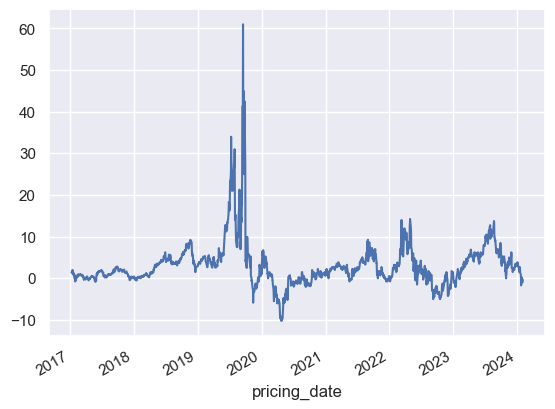

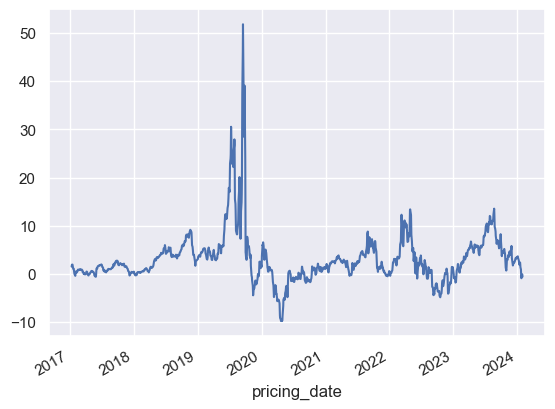

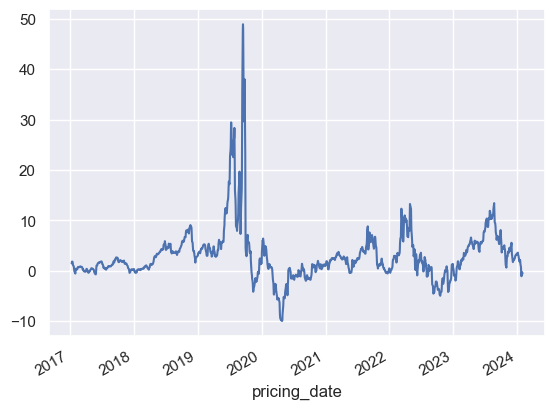

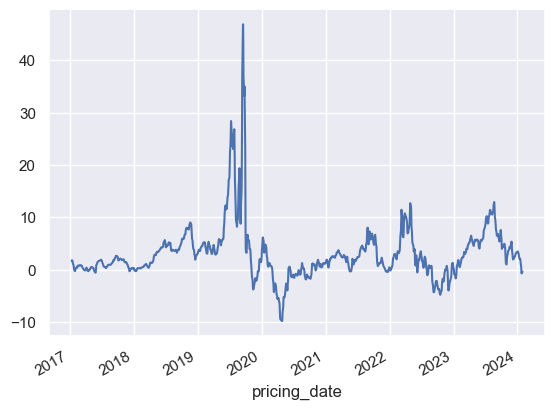

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose


for x in [1, 2, 3, 4]:
    result = seasonal_decompose(target.dropna(), model='additive', period=x)
    result.trend.plot()
    plt.show()

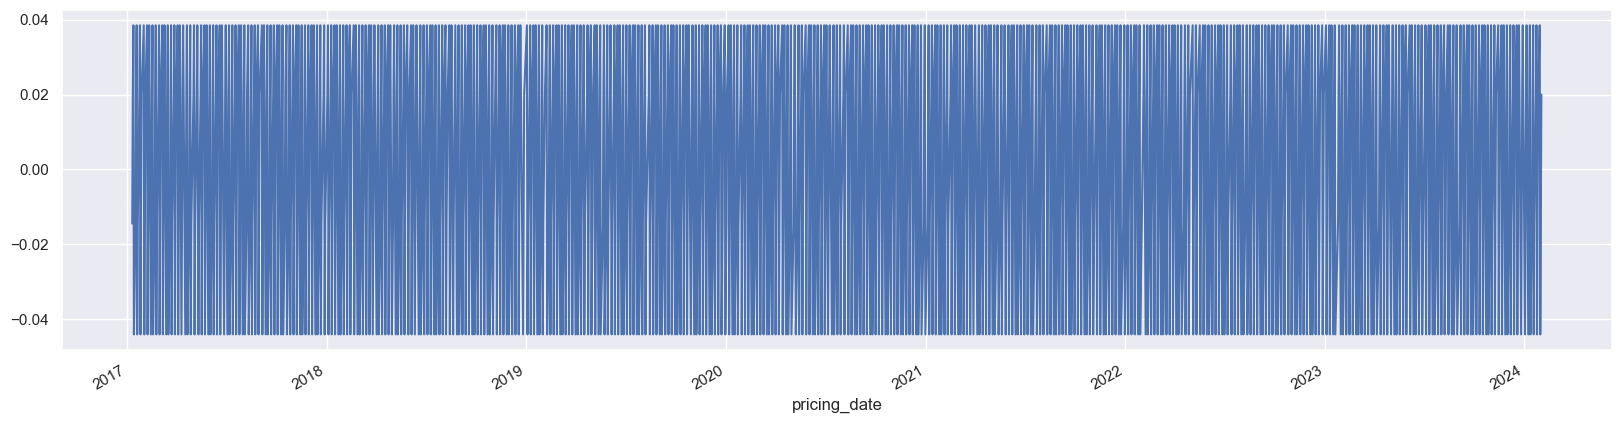

<Axes: xlabel='pricing_date'>

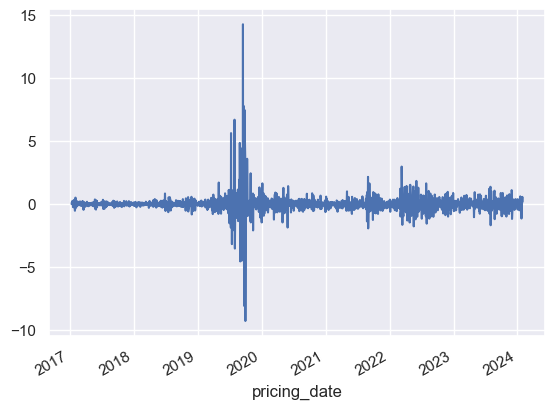

In [74]:
result = seasonal_decompose(target.dropna(), model='additive', period=4)
plt.figure(figsize=(20, 5))
result.seasonal.plot()
plt.show()
result.resid.plot()

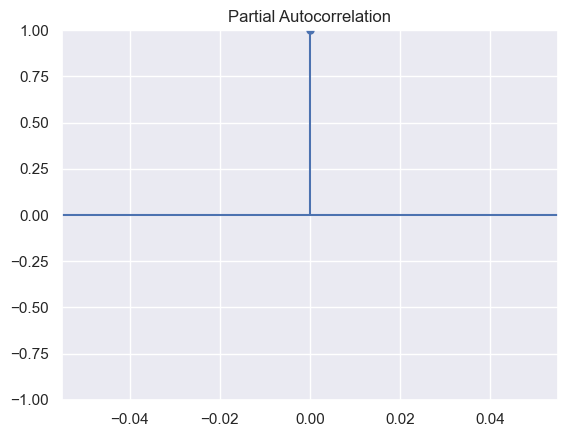

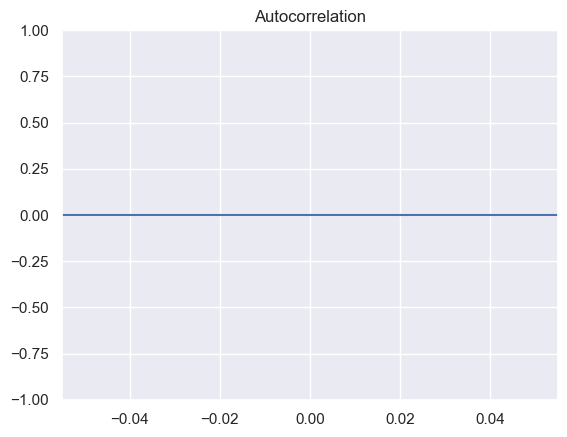

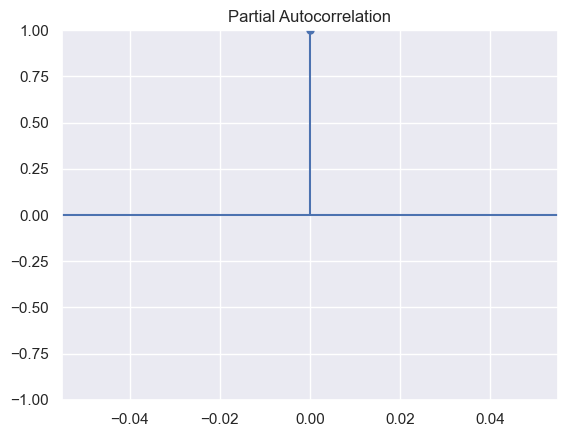

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(target, lags=10)
plot_pacf(target, lags=10)

In [85]:
target_features = target.copy()
target_features['trend'] = result.trend
target_features['seasonal'] = result.seasonal
target_features['residual'] = result.resid

fft_values = np.fft.fft(target.copy())

target_features['fft_real'] = fft_values.real
target_features['fft_imag'] = fft_values.imag

target_features['diff'] = target.diff()
target_features['seasonal_diff'] = target_features['seasonal'].diff()

# target_features['time_since_event'] = (target.index - target.index.shift(freq='D')).days
target_features['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
target_features['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
target_features['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
target_features['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)

<Axes: xlabel='pricing_date'>

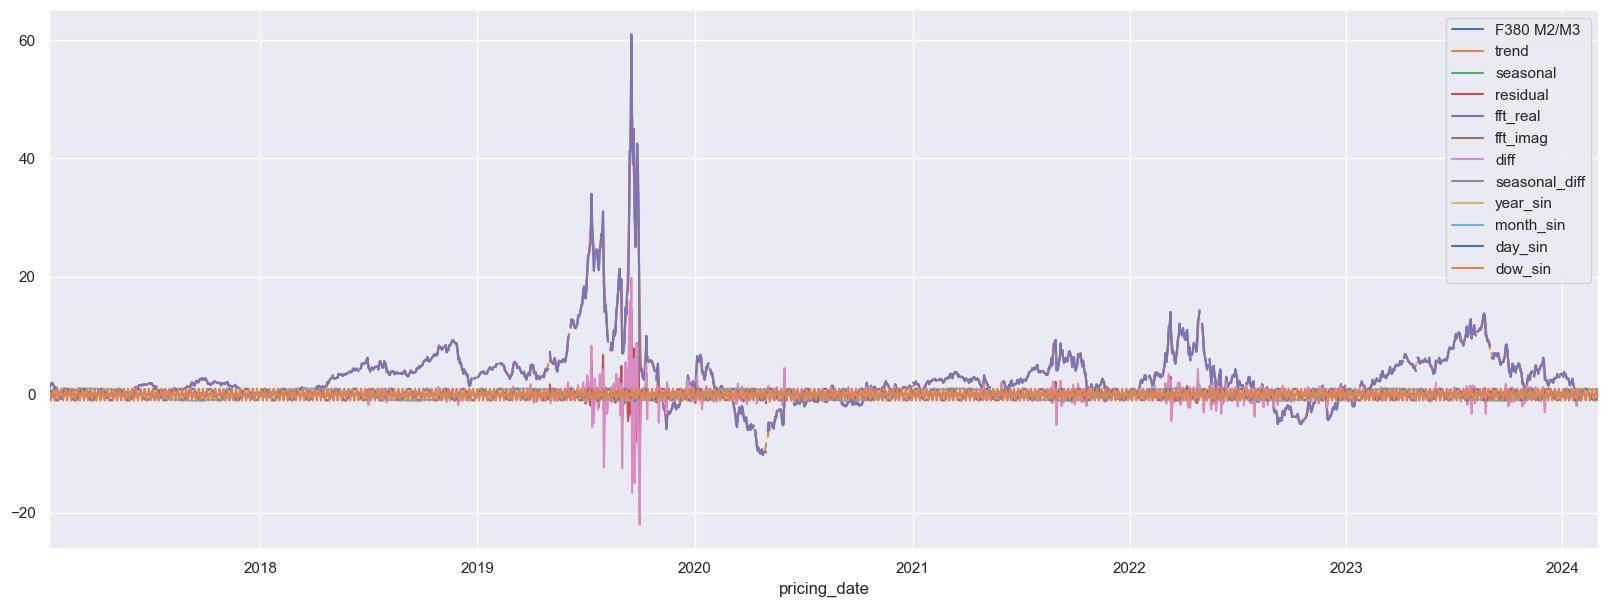

In [88]:
target_features.plot(figsize=(20, 7))

In [119]:
from datetime import timedelta

def train_model(data, train_end, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, 
                final_refit=True, path=None, use_rolling=False):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    model_name = f'experiments/models/model-{model_suffix}-train_end={train_end}-len{len(columns)}.model'
    
    # create a target feature class
    target_feature = TargetFeature(path, data, test_start, test_end)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    # split to train/test
    train = data[data.index <= train_end]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_rolling:
            train_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target, rolling]].values
            valid_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[[target, rolling]].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)

            # normalize rolling
            train_temp['rolling_target5'] = target_feature.scaler.transform(train_temp[['rolling_target5']])
            valid_temp['rolling_target5'] = target_feature.scaler.transform(valid_temp[['rolling_target5']])
        else:
            train_temp[target_col] = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            valid_temp[target_col] = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        train_dm = xgb.DMatrix(train_temp.drop(columns=target_col), label=train_temp[target_col])
        valid_dm = xgb.DMatrix(valid_temp.drop(columns=target_col), label=valid_temp[target_col])

        if idx == 0:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10, custom_metric=custom_pnl_10)
        else:
            model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
                              maximize=True, early_stopping_rounds=10,
                              xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_rolling:
        full_train[[target_col, 'rolling_target5']] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                    include_past=True)[[target, rolling]].values
    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)

    if use_rolling:
        # normalize data
        full_train['rolling_target5'] = target_feature.scaler.transform(full_train[['rolling_target5']])

    train_dm = xgb.DMatrix(full_train.drop(columns=target_col), label=full_train[target_col])

    model = xgb.train(params, train_dm, evals=[(train_dm, 'train')],
                      maximize=True, early_stopping_rounds=10,
                      xgb_model=model_name, custom_metric=custom_pnl_10)

    model.save_model(model_name)

    return model, train, test, scaler, target_feature


def get_columns(columns_selection, model):
    if columns_selection == 'xgboost':
        scores = model.get_score(importance_type='gain')
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] > 30]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_rolling=False):
    # model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, path=results_folder)

    # columns = get_columns(columns_selection, model)
    # print(columns)
    # columns = [x for x in columns if not x.startswith('rolling')]
    # print('Selected columns:', columns)
    
    columns = data.columns
    # columns = [c for c in columns.tolist() if c != 'F380 M2/M3']
    
    train_end_date = datetime.strptime(test_start, '%Y-%m-%d') - timedelta(days=90)
    train_end_date = str(train_end_date)[:10]
    
    # refit the model with selected columns
    model, train, test, scaler, target_feature = train_model(data.copy(), train_end=train_end_date, test_start=test_start, test_end=test_end, 
                                                             model_suffix='partial', columns=columns, path=results_folder, use_rolling=use_rolling)
    

    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    # iterate over values
    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    
                    testx.drop(columns='F380 M2/M3', inplace=True)

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_rolling:
                        # get rolling targets
                        rolling_target = current_targets.rolling(5).mean()
                        rolling_target.dropna(inplace=True)
                        
                        # normalize rolling targets
                        try:
                            rolling_target = pd.DataFrame(target_feature.scaler.transform(rolling_target),
                                                        index=rolling_target.index)
                        except ValueError:
                            rolling_target = pd.DataFrame(
                                target_feature.scaler.transform(rolling_target.values.reshape(-1, 1)),
                                index=rolling_target.index)

                        # put the new value to test set
                        try:
                            testx['rolling_target5'] = rolling_target.iloc[-1, 0]
                        except KeyError:
                            pass
                            
                    # convert test to DMatrix
                    test_dm = xgb.DMatrix(testx)

                    # get predictions
                    prediction = model.predict(test_dm)

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_rolling:
                        # append new rolling value to the predicted feature column
                        inverse = target_feature.scaler.inverse_transform(testx[['rolling_target5']])
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_feature', inverse)


                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)

    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'pnl_path': f'{results_folder}/daily_pnl-for-{test_start}.png',
            'plot_path': f'{results_folder}/plot-for-{test_start}.png', 'model': model}

[0]	valid-rmse:1.45949	valid-pnl:-0.03676
[1]	valid-rmse:1.41486	valid-pnl:-0.10396
[2]	valid-rmse:1.37391	valid-pnl:-0.12230
[3]	valid-rmse:1.33087	valid-pnl:-0.18620
[4]	valid-rmse:1.29489	valid-pnl:0.21836
[5]	valid-rmse:1.25400	valid-pnl:0.27958
[6]	valid-rmse:1.21964	valid-pnl:0.29707
[7]	valid-rmse:1.18595	valid-pnl:0.34606
[8]	valid-rmse:1.14336	valid-pnl:0.38471
[9]	valid-rmse:1.10780	valid-pnl:0.43865
[10]	valid-rmse:1.07261	valid-pnl:0.49295
[11]	valid-rmse:1.04440	valid-pnl:0.49295
[12]	valid-rmse:1.00990	valid-pnl:0.50538
[13]	valid-rmse:0.97876	valid-pnl:0.55783
[14]	valid-rmse:0.94876	valid-pnl:0.60872
[15]	valid-rmse:0.91348	valid-pnl:0.64864
[16]	valid-rmse:0.89703	valid-pnl:0.64877
[17]	valid-rmse:0.86856	valid-pnl:0.69217
[18]	valid-rmse:0.84333	valid-pnl:0.72340
[19]	valid-rmse:0.83816	valid-pnl:0.76940
[20]	valid-rmse:0.81392	valid-pnl:0.79948
[21]	valid-rmse:0.81480	valid-pnl:0.83049
[22]	valid-rmse:0.78924	valid-pnl:0.87008
[23]	valid-rmse:0.76704	valid-pnl:0.8995

[34]	valid-rmse:0.57301	valid-pnl:1.16104
[35]	valid-rmse:0.55737	valid-pnl:1.18228
[36]	valid-rmse:0.54184	valid-pnl:1.20701
[37]	valid-rmse:0.52685	valid-pnl:1.23325
[38]	valid-rmse:0.51271	valid-pnl:1.25266
[39]	valid-rmse:0.49884	valid-pnl:1.27150
[40]	valid-rmse:0.48569	valid-pnl:1.29593
[41]	valid-rmse:0.47265	valid-pnl:1.31218
[42]	valid-rmse:0.46036	valid-pnl:1.32951
[43]	valid-rmse:0.44976	valid-pnl:1.34086
[44]	valid-rmse:0.43659	valid-pnl:1.36168
[45]	valid-rmse:0.42916	valid-pnl:1.36229
[46]	valid-rmse:0.41803	valid-pnl:1.37823
[47]	valid-rmse:0.40657	valid-pnl:1.39455
[48]	valid-rmse:0.40396	valid-pnl:1.39837
[49]	valid-rmse:0.39365	valid-pnl:1.41214
[50]	valid-rmse:0.39366	valid-pnl:1.41611
[51]	valid-rmse:0.38371	valid-pnl:1.43410
[52]	valid-rmse:0.37497	valid-pnl:1.43990
[53]	valid-rmse:0.36582	valid-pnl:1.45327
[54]	valid-rmse:0.35886	valid-pnl:1.45879
[55]	valid-rmse:0.35023	valid-pnl:1.47147
[56]	valid-rmse:0.34067	valid-pnl:1.48574
[57]	valid-rmse:0.33494	valid-pnl:

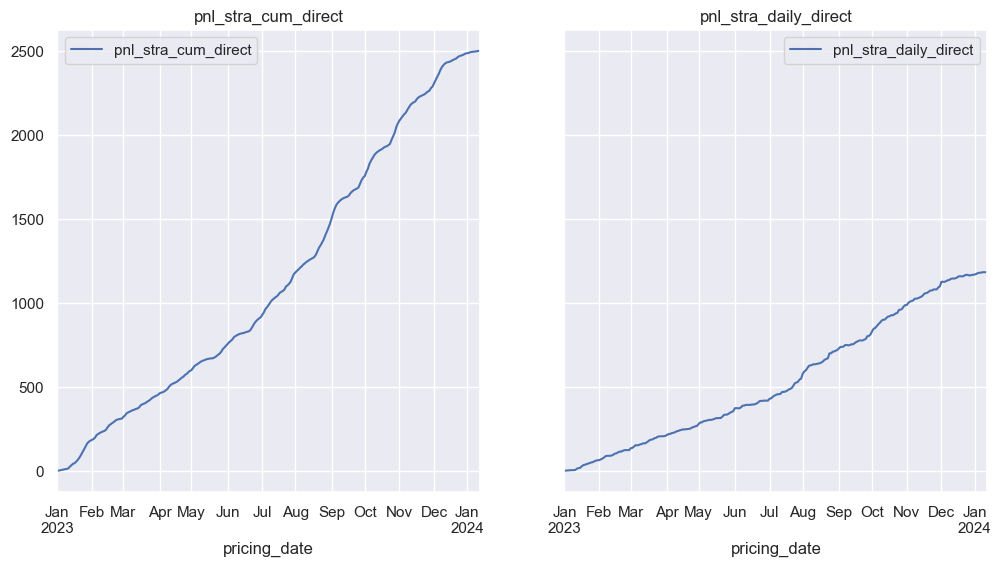

In [98]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/target_features/'
if not os.path.exists(path): os.mkdir(path)

target_features['F380 M2/M3'] = data['F380 M2/M3']
target_features.interpolate('linear', inplace=True)
target_features.dropna(inplace=True)

results = get_predictions(target_features.copy(), path, '2023-01-01', '2023-12-31')

In [100]:
orig_features['F380 M2/M3'] = data['F380 M2/M3']

path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/orig_features/'
if not os.path.exists(path): os.mkdir(path)

orig_features.interpolate('linear', inplace=True)
orig_features.dropna(inplace=True)

feature_results = get_predictions(orig_features.copy(), path, '2023-01-01', '2023-12-31')

[0]	valid-rmse:1.33401	valid-pnl:-0.00000
[1]	valid-rmse:1.29091	valid-pnl:0.02438
[2]	valid-rmse:1.23911	valid-pnl:0.06732
[3]	valid-rmse:1.20266	valid-pnl:0.04540
[4]	valid-rmse:1.16448	valid-pnl:0.04540


[5]	valid-rmse:1.12650	valid-pnl:0.05745
[6]	valid-rmse:1.09280	valid-pnl:0.05745
[7]	valid-rmse:1.06158	valid-pnl:0.08498
[8]	valid-rmse:1.02700	valid-pnl:0.08498
[9]	valid-rmse:1.00071	valid-pnl:0.08498
[10]	valid-rmse:0.98957	valid-pnl:0.08498
[11]	valid-rmse:0.96121	valid-pnl:0.08498
[12]	valid-rmse:0.94361	valid-pnl:0.10894
[13]	valid-rmse:0.94322	valid-pnl:0.06245
[14]	valid-rmse:0.91744	valid-pnl:0.06952
[15]	valid-rmse:0.89419	valid-pnl:0.06952
[16]	valid-rmse:0.87488	valid-pnl:0.06952
[17]	valid-rmse:0.86170	valid-pnl:0.13208
[18]	valid-rmse:0.85764	valid-pnl:0.13208
[19]	valid-rmse:0.85227	valid-pnl:0.18431
[20]	valid-rmse:0.83955	valid-pnl:0.15273
[21]	valid-rmse:0.82368	valid-pnl:0.13148
[22]	valid-rmse:0.81146	valid-pnl:0.13148
[23]	valid-rmse:0.81152	valid-pnl:0.13148
[24]	valid-rmse:0.79316	valid-pnl:0.07135
[25]	valid-rmse:0.79012	valid-pnl:0.07135
[26]	valid-rmse:0.78563	valid-pnl:0.07135
[27]	valid-rmse:0.78491	valid-pnl:0.07135
[28]	valid-rmse:0.78586	valid-pnl:0.060

Error in callback <function flush_figures at 0x000002C4CF5A1360> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [101]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/fusion_model/'
if not os.path.exists(path): os.mkdir(path)

feat_model = train_model(orig_features.copy(), '2023-01-01', '2023-01-01', test_end='2023-12-31', 
                         target_col='F380 M2/M3', model_suffix='full', columns=None, 
                         final_refit=True, path=path, use_rolling=False)

path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/fusion_model/'
if not os.path.exists(path): os.mkdir(path)


targ_model = train_model(target_features.copy(), '2023-01-01', '2023-01-01', test_end='2023-12-31', 
                         target_col='F380 M2/M3', model_suffix='full', columns=None, 
                         final_refit=True, path=path, use_rolling=False)

[0]	valid-rmse:1.33401	valid-pnl:-0.00000
[1]	valid-rmse:1.29091	valid-pnl:0.02438
[2]	valid-rmse:1.23911	valid-pnl:0.06732
[3]	valid-rmse:1.20266	valid-pnl:0.04540
[4]	valid-rmse:1.16448	valid-pnl:0.04540
[5]	valid-rmse:1.12650	valid-pnl:0.05745
[6]	valid-rmse:1.09280	valid-pnl:0.05745
[7]	valid-rmse:1.06158	valid-pnl:0.08498
[8]	valid-rmse:1.02700	valid-pnl:0.08498
[9]	valid-rmse:1.00071	valid-pnl:0.08498
[10]	valid-rmse:0.98957	valid-pnl:0.08498
[11]	valid-rmse:0.96121	valid-pnl:0.08498
[12]	valid-rmse:0.94361	valid-pnl:0.10894
[13]	valid-rmse:0.94322	valid-pnl:0.06245
[14]	valid-rmse:0.91744	valid-pnl:0.06952
[15]	valid-rmse:0.89419	valid-pnl:0.06952
[16]	valid-rmse:0.87488	valid-pnl:0.06952
[17]	valid-rmse:0.86170	valid-pnl:0.13208
[18]	valid-rmse:0.85764	valid-pnl:0.13208
[19]	valid-rmse:0.85227	valid-pnl:0.18431
[20]	valid-rmse:0.83955	valid-pnl:0.15273
[21]	valid-rmse:0.82368	valid-pnl:0.13148
[22]	valid-rmse:0.81146	valid-pnl:0.13148
[23]	valid-rmse:0.81152	valid-pnl:0.13148
[

In [108]:
feat_scaler = feat_model[-2]
target_scaler = targ_model[-2]

In [109]:
feat_model = feat_model[0]
target_model = targ_model[0]

In [112]:
predictions = pd.DataFrame(columns=['pricing_date', 'feature_model', 'target_model', 'combination'])

for date in data[(data.index >= '2023-01-01') & (data.index <= '2023-12-31')].index.tolist():
    x_test = pd.DataFrame(data.loc[date, :]).T
    x_test.drop(columns='F380 M2/M3', inplace=True)
    
    testx = pd.DataFrame(feat_scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    testx = xgb.DMatrix(testx)
    
    feat_pred = feat_model.predict(testx)
    
    # target features
    x_test = pd.DataFrame(target_features.loc[date, :]).T
    x_test.drop(columns='F380 M2/M3', inplace=True)
    testx = pd.DataFrame(target_scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    testx = xgb.DMatrix(testx)
    
    targ_pred = target_model.predict(testx)
    
    
    final_pred = (0.6 * feat_pred) + (0.4 * targ_pred)
    
    print(f'Feature prediction: {feat_pred}\t\t\t Target prediction: {targ_pred}')
    print(f'Final pred: {final_pred}')
    
    predictions = pd.concat([predictions, pd.DataFrame({
        'pricing_date': x_test.index,
        'feature_model': feat_pred,
        'target_model': targ_pred,
        'combination': final_pred
    })])
    
    


Feature prediction: [2.4024632]			 Target prediction: [0.5543239]
Final pred: [1.6632075]
Feature prediction: [2.7532341]			 Target prediction: [-0.7453566]
Final pred: [1.3537979]
Feature prediction: [2.0161848]			 Target prediction: [-1.0800788]
Final pred: [0.77767944]
Feature prediction: [2.4823978]			 Target prediction: [-1.5647858]
Final pred: [0.86352444]
Feature prediction: [1.2085655]			 Target prediction: [-0.8495855]
Final pred: [0.38530514]
Feature prediction: [3.1528656]			 Target prediction: [-0.90795827]
Final pred: [1.5285361]
Feature prediction: [2.822135]			 Target prediction: [-0.8673698]
Final pred: [1.3463331]
Feature prediction: [3.9016707]			 Target prediction: [-1.1574426]
Final pred: [1.8780254]
Feature prediction: [1.1347045]			 Target prediction: [-2.1940174]
Final pred: [-0.19678426]
Feature prediction: [0.99288464]			 Target prediction: [-1.837677]
Final pred: [-0.13934004]
Feature prediction: [0.71948457]			 Target prediction: [-2.2959323]
Final pred: [-0.

In [113]:
predictions

pricing_date  feature_model  target_model  combination
0    2023-01-02       2.402463      0.554324     1.663208
0    2023-01-03       2.753234     -0.745357     1.353798
0    2023-01-04       2.016185     -1.080079     0.777679
0    2023-01-05       2.482398     -1.564786     0.863524
0    2023-01-06       1.208565     -0.849585     0.385305
..          ...            ...           ...          ...
0    2023-12-25       1.179066      3.003157     1.908702
0    2023-12-26       2.121470      3.122101     2.521723
0    2023-12-27       2.587507      3.024468     2.762292
0    2023-12-28       1.692951      3.483854     2.409312
0    2023-12-29       2.500721      3.556420     2.923001

[260 rows x 4 columns]

<Axes: xlabel='pricing_date'>

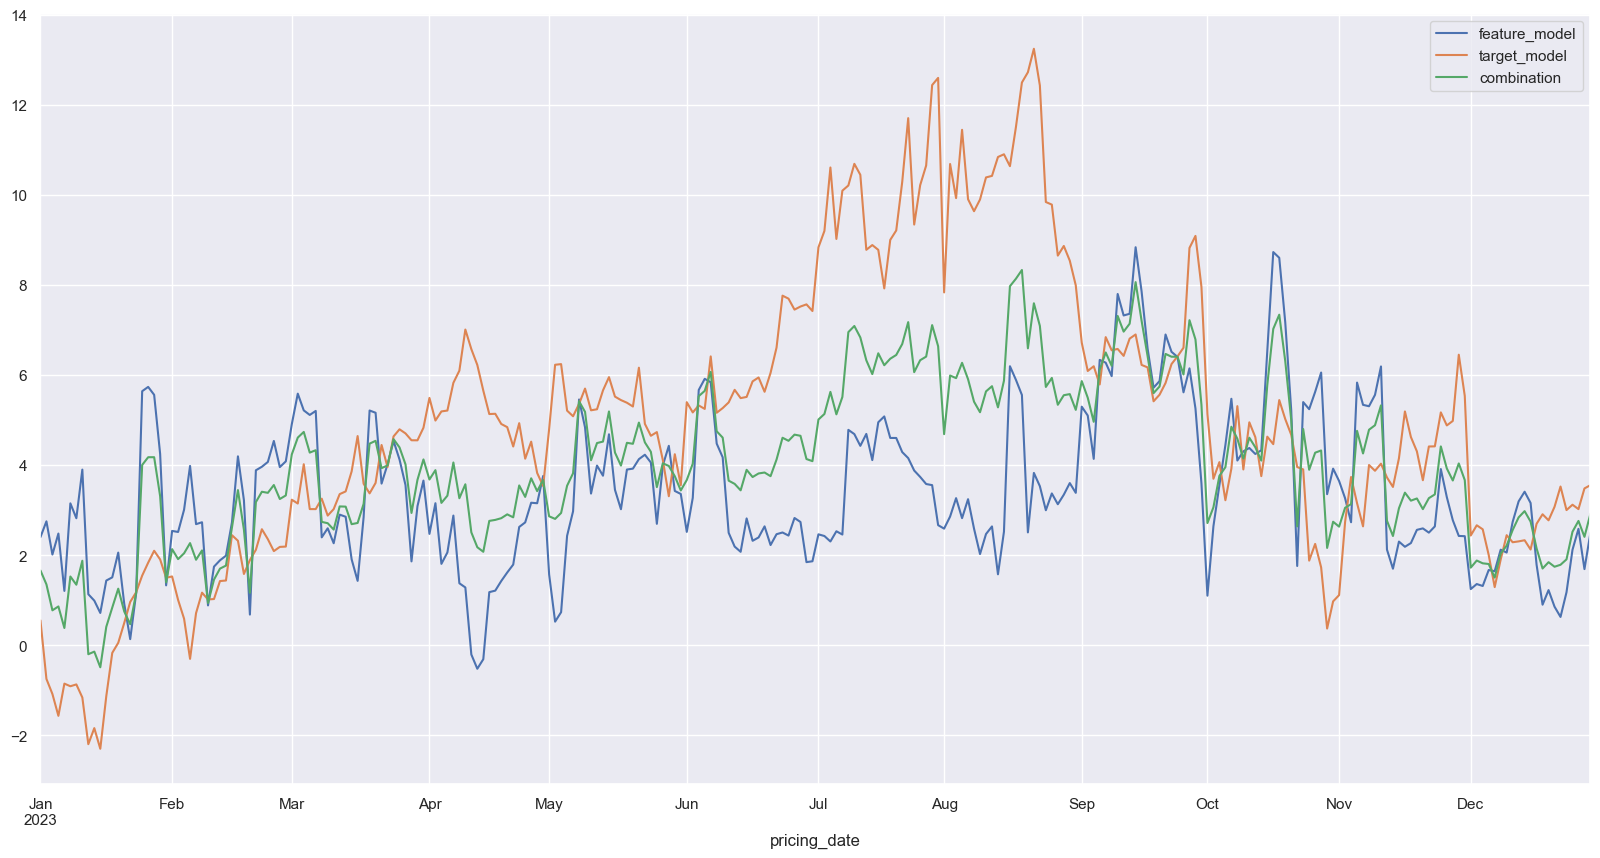

In [114]:
predictions.set_index('pricing_date', inplace=True)
predictions.plot(figsize=(20, 10))

In [115]:
predictions['actual_target'] = data.loc[predictions.index, 'F380 M2/M3']
predictions

feature_model  target_model  combination  actual_target
pricing_date                                                         
2023-01-02         2.402463      0.554324     1.663208            NaN
2023-01-03         2.753234     -0.745357     1.353798          -0.50
2023-01-04         2.016185     -1.080079     0.777679          -1.00
2023-01-05         2.482398     -1.564786     0.863524          -1.10
2023-01-06         1.208565     -0.849585     0.385305          -0.75
...                     ...           ...          ...            ...
2023-12-25         1.179066      3.003157     1.908702            NaN
2023-12-26         2.121470      3.122101     2.521723           2.95
2023-12-27         2.587507      3.024468     2.762292           3.15
2023-12-28         1.692951      3.483854     2.409312           3.45
2023-12-29         2.500721      3.556420     2.923001           3.55

[260 rows x 4 columns]

In [116]:
predictions.interpolate(inplace=True)

In [118]:
import plotly.graph_objs as go
import plotly.offline as pyo

df = predictions.copy()
index = df.index

# Create traces for the four lines
trace1 = go.Scatter(x=index, y=df['actual_target'], mode='lines', name='Original Target', line=dict(width=2))
trace2 = go.Scatter(x=index, y=df['feature_model'], mode='lines', name='Orig Feature Preds', line=dict(width=1))
trace3 = go.Scatter(x=index, y=df['target_model'], mode='lines', name='Target Feature Preds', line=dict(width=1))
trace4 = go.Scatter(x=index, y=df['combination'], mode='lines', name='Combined Feature Preds', line=dict(width=1))

# Create a layout
layout = go.Layout(title='Results Comparison',
                   xaxis=dict(title='X-axis'),
                   yaxis=dict(title='Y-axis'))

# Create a figure with the traces and layout
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

# Customize the visibility of the standout line (Line 1)
fig.update_traces(visible='legendonly', selector=dict(name='Line 1'))

# Display the plot
pyo.iplot(fig)

In [120]:
path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/fusion_model/'
if not os.path.exists(path): os.mkdir(path)

feat_model = train_model(orig_features.copy(), '2023-01-01', '2023-01-01', test_end='2023-12-31', 
                         target_col='F380 M2/M3', model_suffix='full', columns=None, 
                         final_refit=True, path=path, use_rolling=False)

path = 'experiments/test'

if not os.path.exists(path): os.mkdir(path)

path += '/fusion_model/'
if not os.path.exists(path): os.mkdir(path)


targ_model = train_model(target_features.copy(), '2023-01-01', '2023-01-01', test_end='2023-12-31', 
                         target_col='F380 M2/M3', model_suffix='full', columns=None, 
                         final_refit=True, path=path, use_rolling=False)

[0]	valid-rmse:1.33401	valid-pnl:-0.00000
[1]	valid-rmse:1.29091	valid-pnl:0.02438
[2]	valid-rmse:1.23911	valid-pnl:0.06732
[3]	valid-rmse:1.20266	valid-pnl:0.04540
[4]	valid-rmse:1.16448	valid-pnl:0.04540
[5]	valid-rmse:1.12650	valid-pnl:0.05745
[6]	valid-rmse:1.09280	valid-pnl:0.05745
[7]	valid-rmse:1.06158	valid-pnl:0.08498
[8]	valid-rmse:1.02700	valid-pnl:0.08498
[9]	valid-rmse:1.00071	valid-pnl:0.08498
[10]	valid-rmse:0.98957	valid-pnl:0.08498
[11]	valid-rmse:0.96121	valid-pnl:0.08498
[12]	valid-rmse:0.94361	valid-pnl:0.10894
[13]	valid-rmse:0.94322	valid-pnl:0.06245
[14]	valid-rmse:0.91744	valid-pnl:0.06952
[15]	valid-rmse:0.89419	valid-pnl:0.06952
[16]	valid-rmse:0.87488	valid-pnl:0.06952
[17]	valid-rmse:0.86170	valid-pnl:0.13208
[18]	valid-rmse:0.85764	valid-pnl:0.13208
[19]	valid-rmse:0.85227	valid-pnl:0.18431
[20]	valid-rmse:0.83955	valid-pnl:0.15273
[21]	valid-rmse:0.82368	valid-pnl:0.13148
[22]	valid-rmse:0.81146	valid-pnl:0.13148
[23]	valid-rmse:0.81152	valid-pnl:0.13148
[

In [121]:
feat_scaler = feat_model[-2]
target_scaler = targ_model[-2]
feat_model = feat_model[0]
target_model = targ_model[0]

predictions = pd.DataFrame(columns=['pricing_date', 'feature_model', 'target_model', 'combination'])

for date in data[(data.index >= '2023-01-01') & (data.index <= '2023-12-31')].index.tolist():
    x_test = pd.DataFrame(data.loc[date, :]).T
    x_test.drop(columns='F380 M2/M3', inplace=True)
    
    testx = pd.DataFrame(feat_scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    testx = xgb.DMatrix(testx)
    
    feat_pred = feat_model.predict(testx)
    
    # target features
    x_test = pd.DataFrame(target_features.loc[date, :]).T
    x_test.drop(columns='F380 M2/M3', inplace=True)
    testx = pd.DataFrame(target_scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    testx = xgb.DMatrix(testx)
    
    targ_pred = target_model.predict(testx)
    
    
    final_pred = (0.6 * feat_pred) + (0.4 * targ_pred)
    
    print(f'Feature prediction: {feat_pred}\t\t\t Target prediction: {targ_pred}')
    print(f'Final pred: {final_pred}')
    
    predictions = pd.concat([predictions, pd.DataFrame({
        'pricing_date': x_test.index,
        'feature_model': feat_pred,
        'target_model': targ_pred,
        'combination': final_pred
    })])
    
    


Feature prediction: [2.4024632]			 Target prediction: [0.5543239]
Final pred: [1.6632075]
Feature prediction: [2.7532341]			 Target prediction: [-0.7453566]
Final pred: [1.3537979]
Feature prediction: [2.0161848]			 Target prediction: [-1.0800788]
Final pred: [0.77767944]
Feature prediction: [2.4823978]			 Target prediction: [-1.5647858]
Final pred: [0.86352444]
Feature prediction: [1.2085655]			 Target prediction: [-0.8495855]
Final pred: [0.38530514]
Feature prediction: [3.1528656]			 Target prediction: [-0.90795827]
Final pred: [1.5285361]
Feature prediction: [2.822135]			 Target prediction: [-0.8673698]
Final pred: [1.3463331]
Feature prediction: [3.9016707]			 Target prediction: [-1.1574426]
Final pred: [1.8780254]
Feature prediction: [1.1347045]			 Target prediction: [-2.1940174]
Final pred: [-0.19678426]
Feature prediction: [0.99288464]			 Target prediction: [-1.837677]
Final pred: [-0.13934004]
Feature prediction: [0.71948457]			 Target prediction: [-2.2959323]
Final pred: [-0.

In [124]:
import plotly.graph_objs as go
import plotly.offline as pyo

predictions.set_index('pricing_date', inplace=True)
predictions['actual_target'] = data.loc[predictions.index, 'F380 M2/M3']
predictions.interpolate(inplace=True)

df = predictions.copy()
index = df.index

# Create traces for the four lines
trace1 = go.Scatter(x=index, y=df['actual_target'], mode='lines', name='Original Target', line=dict(width=2))
trace2 = go.Scatter(x=index, y=df['feature_model'], mode='lines', name='Orig Feature Preds', line=dict(width=1))
trace3 = go.Scatter(x=index, y=df['target_model'], mode='lines', name='Target Feature Preds', line=dict(width=1))
trace4 = go.Scatter(x=index, y=df['combination'], mode='lines', name='Combined Feature Preds', line=dict(width=1))

# Create a layout
layout = go.Layout(title='Results Comparison',
                   xaxis=dict(title='X-axis'),
                   yaxis=dict(title='Y-axis'))

# Create a figure with the traces and layout
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

# Customize the visibility of the standout line (Line 1)
fig.update_traces(visible='legendonly', selector=dict(name='Line 1'))

# Display the plot
pyo.iplot(fig)

# More weight on target feature

In [126]:
# feat_scaler = feat_model[-2]
# target_scaler = targ_model[-2]
# feat_model = feat_model[0]
# target_model = targ_model[0]

predictions = pd.DataFrame(columns=['pricing_date', 'feature_model', 'target_model', 'combination'])

for date in data[(data.index >= '2023-01-01') & (data.index <= '2023-12-31')].index.tolist():
    x_test = pd.DataFrame(data.loc[date, :]).T
    x_test.drop(columns='F380 M2/M3', inplace=True)
    
    testx = pd.DataFrame(feat_scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    testx = xgb.DMatrix(testx)
    
    feat_pred = feat_model.predict(testx)
    
    # target features
    x_test = pd.DataFrame(target_features.loc[date, :]).T
    x_test.drop(columns='F380 M2/M3', inplace=True)
    testx = pd.DataFrame(target_scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    testx = xgb.DMatrix(testx)
    
    targ_pred = target_model.predict(testx)
    
    
    final_pred = (0.4 * feat_pred) + (0.6 * targ_pred)
    
    print(f'Feature prediction: {feat_pred}\t\t\t Target prediction: {targ_pred}')
    print(f'Final pred: {final_pred}')
    
    predictions = pd.concat([predictions, pd.DataFrame({
        'pricing_date': x_test.index,
        'feature_model': feat_pred,
        'target_model': targ_pred,
        'combination': final_pred
    })])
    
    


Feature prediction: [2.4024632]			 Target prediction: [0.5543239]
Final pred: [1.2935797]
Feature prediction: [2.7532341]			 Target prediction: [-0.7453566]
Final pred: [0.6540797]
Feature prediction: [2.0161848]			 Target prediction: [-1.0800788]
Final pred: [0.15842658]
Feature prediction: [2.4823978]			 Target prediction: [-1.5647858]
Final pred: [0.05408758]
Feature prediction: [1.2085655]			 Target prediction: [-0.8495855]
Final pred: [-0.02632514]
Feature prediction: [3.1528656]			 Target prediction: [-0.90795827]
Final pred: [0.7163713]
Feature prediction: [2.822135]			 Target prediction: [-0.8673698]
Final pred: [0.6084322]
Feature prediction: [3.9016707]			 Target prediction: [-1.1574426]
Final pred: [0.8662028]
Feature prediction: [1.1347045]			 Target prediction: [-2.1940174]
Final pred: [-0.86252874]
Feature prediction: [0.99288464]			 Target prediction: [-1.837677]
Final pred: [-0.70545244]
Feature prediction: [0.71948457]			 Target prediction: [-2.2959323]
Final pred: [-1

In [128]:
predictions.set_index('pricing_date', inplace=True)
predictions['actual_target'] = data.loc[predictions.index, 'F380 M2/M3']
predictions.interpolate(inplace=True)
predictions

feature_model  target_model  combination  actual_target
pricing_date                                                         
2023-01-02         2.402463      0.554324     1.293580            NaN
2023-01-03         2.753234     -0.745357     0.654080         -0.500
2023-01-04         2.016185     -1.080079     0.158427         -1.000
2023-01-05         2.482398     -1.564786     0.054088         -1.100
2023-01-06         1.208565     -0.849585    -0.026325         -0.750
...                     ...           ...          ...            ...
2023-12-25         1.179066      3.003157     2.273520          3.225
2023-12-26         2.121470      3.122101     2.721849          2.950
2023-12-27         2.587507      3.024468     2.849684          3.150
2023-12-28         1.692951      3.483854     2.767493          3.450
2023-12-29         2.500721      3.556420     3.134140          3.550

[260 rows x 4 columns]

In [130]:
import plotly.graph_objs as go
import plotly.offline as pyo

# predictions.set_index('pricing_date', inplace=True)
# predictions['actual_target'] = data.loc[predictions.index, 'F380 M2/M3']
# predictions.interpolate(inplace=True)

df = predictions.copy()
index = df.index

# Create traces for the four lines
trace1 = go.Scatter(x=index, y=df['actual_target'], mode='lines', name='Original Target', line=dict(width=2))
trace2 = go.Scatter(x=index, y=df['feature_model'], mode='lines', name='Orig Feature Preds', line=dict(width=1))
trace3 = go.Scatter(x=index, y=df['target_model'], mode='lines', name='Target Feature Preds', line=dict(width=1))
trace4 = go.Scatter(x=index, y=df['combination'], mode='lines', name='Combined Feature Preds', line=dict(width=1))

# Create a layout
layout = go.Layout(title='Results Comparison',
                   xaxis=dict(title='X-axis'),
                   yaxis=dict(title='Y-axis'))

# Create a figure with the traces and layout
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)

# Customize the visibility of the standout line (Line 1)
fig.update_traces(visible='legendonly', selector=dict(name='Line 1'))

# Display the plot
pyo.iplot(fig)